# Gas Phase UED Processing Code
Written by LFH in Oct 2023. 
Adapted from code provided by Yusong Liu and Caidan Moore

## Standard Steps

1. __Reject images with high counts.__
    * Compared total counts of each image. This is done either based on selected images or based on the standard deviaion of all the images. 
2. __Optional: Subtract background images__
    * Some experiments collect background shots. An average of these is taken and the average is subtracted from each data image. 
    * Alternative method is to generate a background based on the average values of the corners of the images. Right now this is behaving poorly for me.  
3. __Remove outliers instances of identical pixels.__
    * This is generally referred to as removing xray hits or hot pixels. There are two functions for doing this. `rmv_xray_all` runs in parallel and should be used for large datasets and `cleanMean` takes in small data sets.
4. __Mask detector hole__
    * Currently using the code made by collaborators at SLAC as it automatically finds the mask position. This function uses the opencv package. Replaces the mask with nan values.  
5. __Calculate static diffraction center.__
    * Using the method provided by collaborators at SLAC found in the `find_beam_center` function. Iteratively fits a circle to the data based on equivalent values in radial positions.  
6. __Remove radial outliers.__
    * Filter out values which are beyond a threshold compared to equivalent values at other radial positions. This is automatically done in the `azimuthal_avg_correct` function which runs in the background in parallel when calling `get_azimuthal_average`. This function currently uses the multiprocessing package. Would like to switch to concurrent.futures package. __Need to edit__
7. __Apply median filter.__
    * Applies a median filter using the `scipy.ndimage.median_filter` function which requires a set size of grid to filter based on. Before doing this, need to change all nan values to their radial average equivalent.
8. __Calculate azimuthal average.__
    * See point 6. Repeat calculation.


### To Do

* Make more cleaning functions and organize them
* Make flexible by using consistent names for things
* Make center finding run in parallel
* Create simulated difference diffraction package
* Explore code for time evolving diffraction simulations

## Import Necessary Functions

In [1]:
# Standard Packages
import numpy as np
from math import exp, sqrt, floor
from tifffile import tifffile as tf
import glob
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy.ma as ma
import scipy.signal as ss
import scipy.interpolate as interp
from scipy.optimize import curve_fit
from scipy.signal import medfilt2d
from scipy.ndimage import median_filter
from scipy.ndimage import gaussian_filter
import skimage.transform as skt
import concurrent.futures
import matplotlib

#Image stuff
import matplotlib.patches as patches
from PIL import Image
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops_table
from skimage import util
import cv2
from pybaselines import Baseline

#ff stuff
import os
from multiprocessing.dummy import Pool as ThreadPool

## Define Functions

### Processing Files

In [2]:
def get_data(file_path, shape = False, file_names = False):
    """
    Generates an array of images of TIFF files.
    
    Arguments:
    
    file_path (string) = Path containing the UED TIFF files. Path can be for a singular image or for a folder containing
                        many files. See examples below for example using //*// format style.
    shape (bool, optional) = Boolean expression. If set to True, function returns the shape of the image data array.
    file_names (bool, optional) = Boolean Expression. If set to true, function returns the list of file names.
    
    Returns: data_array, shape (if True), file_names (if True)
    
    numpy array or tuple: 
            If shape = False, file_names = False: Returns numpy array containing data from tiff files as a n x shape x shape (shape refers to the
                                dimensions of the TIFF file, typically 1024 x 1024).
            If shape = True: returns tuple. First element is a numpy array containing data from tiff files as a n x shape x shape
                                (shape refers to the dimensions of the TIFF file, typically 1024 x 1024). Second element is the dimensions
                                of the data array as a tuple.
            If file_names = True: returns tuple containing data array and list with file names.
            
    
    Examples:
    
    file_path = "Desktop/Folder/Data_Analysis/20034291//*//*//ANDOR1_*.tif"
    
    >>>fileReading(file_path)
        [[data1], ..., [dataN]]
    
    >>>fileReading(file_path)
        [[data1], ..., [dataN]], (220, 1024, 1024)
    
    Notes:
        - All images must be of same dimension. If images of different shapes needed, either group them by shape and run this function for
            each file shape or create it manually by reading files into a numpy array with dtype = object. Be careful as this can lead to 
            later problems
        - Review "*" notation to read in all files of a singular type. Expedites the process.
    
    """
    files = glob.glob(file_path) #read in file name
    if not files:
        FileNotFoundError(f"file_path input does not contain any TIFF files: {file_path}")
    data_array = tf.imread(files) # construct array containing files
    if shape and file_names:
        return data_array, data_array.shape, files
    elif shape:
        return data_array, data_array.shape
    elif file_names:
        return data_array, files
    else:
        return data_array
    
def stagePosition(file_names, idx_start, idx_end, unique_positions = False ):
    """
    Finds the stage position in the string for every file name in the list of all TIFF files. Requires the user to find the
    index of the first digit and last digit of a single file and assumes all files are formatted identically. It uses these indices
    to retrieve the digits from the file names and stores them in a list. All files must have the exact same number of characters before
    the stage position in the name of the file. If this is an issue, group the file names by preceding characters and run this function
    on each list of files.
    
    If unique_positions = False, it returns the stage positions as a numpy array. If unique_positions = True, it returns a tuple
                        containing an array of the stage positions, an array of the unique stage positions, and an array containing
                        the indices of the unique stage positions in the original array.
    Arguments: 
    
    file_names (list containing strings): List of file names
    idxStart (int): the index of the first digit of the stage position in the file name
    idxEnd (int): the index of the last digit of the stage position in the file name
    unique_positions
    
    Returns: stage_pos, uniq_stage (optional), uniq_stage_idx (optional)
    
    stage_pos (array): Default. A numpy array containing the stage positions of the file. The index of each stage position corresponds to
                            the index of the file name in file_names.
    uniq_stage (array): Optional. A numpy array containing the unique stage positions listed in ascending order.
    uniq_stage_idx (array): Optional. A numpy array containing the indices of the unique stage positions in the original input array.
    
    Examples:
    
    file_names = ['image001_10.tif', 'image002_20.tif', 'image004_40.tif', 'image003_30.tif', 'image004_40.tif']
    >>> stagePosition(file_names, 9, 11)
        [10. 20. 40. 30. 40.]
    
    >>> stagePosition(file_names, 9, 11, unique_positions = True)
        (array([10., 20., 40., 30., 40.]), array([10., 20., 30., 40.]), array([0, 1, 3, 2]))

    """
    try:
        try:
            stage_pos = [np.float64(file_name[idx_start:idx_end]) for file_name in file_names]
            stage_pos = np.array(stage_pos)
            if unique_positions == True:
                uniq_stage, uniq_stage_idx = np.unique(stage_pos, return_index = True)
                return stage_pos, uniq_stage, uniq_stage_idx
            else:
                return stage_pos
            return stagePos
        except ValueError:
            raise ValueError("""Failed to convert a file name to a float. Make sure that index positions are correct for all files in file_names.""")
    except IndexError:
        raise ValueError("Invalid index values. Make sure the index values are within the range of the file name strings.")

def get_counts(data_array, plot = False):
    """
    Generates the counts from the given data by summing over the array elements. Returns 2d array of the same dimension as the
    input images.
    
    Arguments:
    
    data_array (numpy.ndarray): Numpy data array containing the diffraction images.
    plot (bool, optional): If set to true, generates a graph of the counts data.
    
    Returns:
    counts (numpy.ndarray): One dimensional numpy array containing the data after summing over each array element.
    
    Example:
    
    data = np.array([[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [10, 11, 12]]])
    >>>countData(data)
        array([21, 51])
    """
    counts = np.sum(data_array, axis = (1,2))
    if len(data_array) == 0:
        raise ValueError("Input data_array is empty.")
    if data_array.ndim != 3:
        raise ValueError("Input data_array is not 3 dimensional.")
    if plot == True:
        plt.plot(np.arange(len(data_array[:, 0, 0])), counts)
        plt.show()
    return counts

def get_image_details(file_names):
    """
    Returns the data loaded from the tif files with a floor subtracted based on the median of the corner. Also returns arrays with the stage positions, the
    file order number, and the number of counts per image.
    
    Arguments: 
    data_array (numpy.ndarray): Numpy data array containing the diffraction images.
    file_names = ['image001_10.tif', 'image002_20.tif', 'image004_40.tif', 'image003_30.tif', 'image004_40.tif']
    
    Returns:
    data_array (ndarray): Array of N x 1024 x 1024 where N is the length of tile file_names list. Generated by using tifffile as tf.
    stage_pos (array): Default. A numpy array containing the stage positions of the file. The index of each stage position corresponds to
                            the index of the file name in file_names.
    file_order (array): Returns the image number located in the file name. Reflects the order with which the images are taken. 
    counts(ndarray): One dimensional numpy array of length N containing the data after summing over each array element.

    """
    data_array = tf.imread(file_names) # construct array containing files
    
    try:
        stage_pos = []
        file_order = []
        try:
            #stage_pos = [np.float64(file_name[idx_start:idx_end]) for file_name in file_names]
            #stage_pos = np.array(stage_pos)
            for file in file_names:
                string = list(map(str, file.split("/")))
                string = list(map(str, string[-1].split("-")))
                file_order.append(int(string[1]))
                string = list(map(str, string[-1].split("_")))
                stage_pos.append(float(string[0]))
        except ValueError:
            raise ValueError("""Failed to convert a file name to a float. Make sure that index positions are correct for all files in file_names. Also check separators""")
    except IndexError:
        raise ValueError("Invalid index values. Make sure the index values are within the range of the file name strings.")
    
    stage_pos = np.array(stage_pos)
    file_order = np.array(file_order)
    
    counts = get_counts(data_array)
    
    return data_array, stage_pos, file_order, counts 



### Cleaning Functions

In [27]:
def clean_and_filter(data_array):
    """Takes in a 3D array of data and applies the scipy.ndimage.median_filter on them. Need to consider the box size for these filters. 
        Additionally, issues can arise if the data array has nan values. 
        
        Returns: filtered data array of the same size as the input array"""
    
    print("Cleaning data")
    clean_data_array = []
    for data in data_array:
        new_data = data
        filt_data = mediand_filter(new_data, size=5)
        clean_data_array.append(np.array(filt_data))
    
    return clean_data_array

def _clean_and_filter(data_array_1d):
    """Takes in a large 3D array of data and applies the scipy.ndimage.median_filter on them in parallel processing. 
    Need to consider the box size for these filters. Additionally, issues can arise if the data array has nan values. Eventually would like to add
    A baseline subtraction to this code.

    Returns: filtered data array of the same size as the input array"""
    
    #corners = (np.median(data_array_1d[-50:, -50:]), np.median(data_array_1d[-50:, :50]), np.median(data_array_1d[:50, -50:]), 
                    #np.median(data_array_1d[:50, :50]))
    #floor = float(np.mean(corners))
    new_data = data_array_1d
    filt_data = median_filter(new_data, size=5)
    
    return filt_data


def clean_all(data_array):
    """Takes in a large 3D array of data and applies the scipy.ndimage.median_filter on them in parallel processing using the hidden function
    _clean_and_filter. Need to consider the box size for these filters. Additionally, issues can arise if the data array has nan values. 
    Eventually would like to add a baseline subtraction to this code.

    Returns: filtered data array of the same size as the input array"""
    
    print('Cleaning all data with concurrent.futures.ProcessPoolExecutor')
    filtered_data = []
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(_clean_and_filter, data_array)
        
    for result in results:
        filtered_data.append(result)
    
    filtered_data = np.array(filtered_data)
    print(filtered_data.shape)
    print("Finished cleaning!!")
    return filtered_data

def rmv_xrays_all(data_array):
    """ Requires global variables for the mean and standard deviation. Filters out any pixels that are more than 4 times the standard deviation of the average
    pixel value by running the hidden function _remove_xrays in parallel. Use cleanMean if not a large dataset.
    
    Returns: xray removed data sets of the same shape."""
    print("Removing xrays from all data")
    clean_data = []
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(_remove_xrays, data_array)
    for result in results:
        clean_data.append(result)
    pct_rmv = []
    for i in range(len(clean_data)):
        no_rmv = sum(sum(clean_data[i].mask))
        pct_rmv.append(no_rmv/(1024*1024) * 100)
    clean_data = np.array(clean_data)
    print(clean_data.shape)
    
    pct_rmv = np.array(pct_rmv)
    plt.figure()
    plt.plot(pct_rmv)
    plt.title("Percent Pixels Removed")
    plt.xlabel("Image Number")
    plt.ylabel("Percent")
    plt.show()
    
    return clean_data
        

def _remove_xrays(data_array_1d):
    upper_threshold = mean_data + 4*std_data
    clean_data = ma.masked_greater_equal(data_array_1d, upper_threshold)
    return clean_data
            
def cleanMean(data_array, std = 4, return_clean_data = True):
    """
    Takes in a data array and calculate the mean and standard deviation at each index across all images. Then applies a filter
    to the data that masks all values (replaces outliers with nan's) outside a given number of standard deviations. After, the 
    mean is taken, returning a 2 dimensional array with the mean data of non-outlier entries across all images.
    
    If return_clean_data is set to True, the cleaned data is returned as a 3d array without having the mean taken.
    
    Arguments:
    
    data_array (numpy.ndarray): Data array containing diffraction image data.
    std (int or float): Number of standard deviations from the mean allowed. Values outside this number of standard deviations
                        are masked as nan's. Set to 3 by default.
                        
    Returns:
    
    clean_mean_data (numpy.ndarray): Default. Returns a 2 dimensional array containing the mean values of the cleaned data.
    clean_data (numpy.ndarray): Other option. Returns the raw 3 dimensional array containing the cleaned data.
    
    Examples:
    
    example_array = np.array([[[8.,2],[1,2]], [[1.,2],[1,2]], [[1.,2],[1,2]], [[1., 2], [1,2]]])
    
    >>> cleanMean(example_array, std=1)
        np.array([[1.,2],[1.,2]])
    
    >>> cleanMean(example_array, std=1, return_clean_data = True)
        np.array([[[np.nan, 2],[1,2]], [[1.,2],[1,2]], [[1.,2],[1,2]], [[1.,2],[1,2]]])
    """
    if len(data_array) == 0:
        raise ValueError("Input data array is empty.")
    if data_array.ndim != 3:
        raise ValueError("Input data array is not 3 dimensional.")
    if std <= 0:
        raise ValueError("Number of standard deviations (std) must be non-negative.")
    if not isinstance(return_clean_data, bool):
        raise TypeError("return_clean_data must be a boolean value.")
   
    mean = np.mean(data_array, axis = 0)
    stDev = np.std(data_array, axis = 0)
    upper_threshold = mean + std*stDev
    #lower_threshold = mean - std*stDev
    clean_data = ma.masked_greater_equal(data_array, upper_threshold)
    #clean_data = ma.masked_outside(data_array, lower_threshold, upper_threshold)
    pct_rmv = []
    for i in range(len(clean_data)):
        no_rmv = sum(sum(clean_data[i].mask))
        pct_rmv.append(no_rmv/(1024*1024) * 100)

    pct_rmv = np.array(pct_rmv)
    plt.figure()
    plt.plot(pct_rmv)
    plt.title("Percent Pixels Removed")
    plt.xlabel("Image Number")
    plt.ylabel("Percent")
    plt.show()
    if return_clean_data == True:
        return clean_data
    else:
        clean_mean_data = np.mean(clean_data, axis = (0))
        return clean_mean_data
    
def medianFilter(data_array, center_top_left_corner, center_border_length, med_filter_range = 3):
    """
    Takes in a data array and applies scipy.signal's median filter. Then replaces the boundary and center values with the
    original values from the input array as to not lose precision in these parts. 
    
    Arguments:
    
    data_array (np.array): 2d Numpy array containing diffraction image data.
    center_top_left_corner (tuple): Tuple containing the row index (integer) and column index (integer) of the top left corner
                                    (lowest_index_row, lowest_index_column)
    center_border_length (int): Length of one side of the square. Must be an integer.
    med_filter_range (int): Must be odd. Initially set to 3. Shape of the square array for median filtering. Using an odd values makes it so that the 
                            median filter is centered around the individual point.
    
    Returns:
    
    med_filt_data (2d-array): Array containing the median filtered data.
            
    """
    if not isinstance(data_array, np.ndarray):
        raise ValueError("Input data_array must be a 2D numpy array.")
    if not isinstance(center_top_left_corner, tuple) or len(center_top_left_corner) != 2:
        raise ValueError("Center top left corner must be a tuple of length 2 that contains two integers.")
    if not isinstance(center_border_length, int):
        raise ValueError("center_border_length must be an integer.")
    #if not isinstance(center_top_left_corner[0] + center_border_length < data_array[0,-1]  
    if not (0 <= center_top_left_corner[0] < data_array.shape[0] and
        0 <= center_top_left_corner[1] < data_array.shape[1] and
        center_top_left_corner[0] + center_border_length <= data_array.shape[0] and
        center_top_left_corner[1] + center_border_length <= data_array.shape[1]):
        raise ValueError("""center_top_left_corner is out of bounds or adding center_border_length goes beyond the array.
                     Check that the tuple values are positive integers within the bounds of the data array and that 
                     adding the border length does not result in a value beyond the size of the array.""")
    if not isinstance(med_filter_range, int) and med_filter_range % 2 == 1:
        raise ValueError("med_filter_range must be an odd integer.")

    med_filt_data = ss.medfilt2d(data_array, med_filter_range)
    med_filt_data[0:med_filter_range//2,:] = data_array[0:med_filter_range//2,:]
    med_filt_data[-(med_filter_range//2):0,:] = data_array[-(med_filter_range//2):0,:]
    med_filt_data[:,0:med_filter_range//2] = data_array[:,0:med_filter_range//2]
    med_filt_data[:,-(med_filter_range//2):] = data_array[:,-(med_filter_range//2):]
    row_s, col_s = center_top_left_corner
    row_e, col_e = row_s+center_border_length, col_s+center_border_length
    med_filt_data[row_s:row_e,col_s:col_e] = data_array[row_s:row_e,col_s:col_e]
    return med_filt_data

def backgroundNoise(data_array, bkg_range = 20, remove_noise = False):
    """
    Takes in a 2d data array (using the mean array is recommended) and calculatees the means of the corners. Linearly interpolates values across 2d array to 
    generate of background noise values using pandas.DataFrame.interpolate. Returns a two dimensional numpy array with the linearly interpolated
    background noise.

    Arguments:

    data_array (2d np.ndarray): Data array used to generate the corner values of the background noise.
    bkg_range (int): Side length of square in each corner used for generating mean value. Initially set to 20.
    remove_noise (Bool): If set to true, generated background values are subtracted from the initial input array. Returns cleaned data.
    
    Returns:
    
    bkg_data (2d np.ndarray): Data array containing the linearly interpolated background noise for the image. If remove_noise = True,
                                returned data has background noise removed from original input.
    """
    if not isinstance(data_array, np.ndarray):
        raise ValueError("Input data_array must be a numpy array.")
    if not isinstance(bkg_range, int) and bkg_range > 0:
        raise ValueError("bkg_range must be an integer > 0.")
    if not isinstance(remove_noise, bool):
        raise ValueError("remove_noise must be a boolean.")
    if not (2 * bkg_range < len(data_array[0,:]) and
            2 * bkg_range < len(data_array[:,0])):
        raise ValueError("2 * bkg-range must be less than both the number of rows and the number of columns.")

    empty_array = np.empty(np.shape(data_array))
    empty_array = (ma.masked_array(empty_array, mask = True))
    empty_array[0,0] = np.mean(data_array[0:20,0:20])
    empty_array[-1,0] = np.mean(data_array[-20:,0:20])
    empty_array[0,-1] = np.mean(data_array[0:20,-20:])
    empty_array[-1,-1] = np.mean(data_array[-20:,-20:])
    empty_array = pd.DataFrame(empty_array).interpolate(axis = 0)
    empty_array = pd.DataFrame(empty_array).interpolate(axis = 1)
    bkg_data = pd.DataFrame.to_numpy(empty_array)
    if remove_noise == True:
        return data_array - bkg_data
    else:
        return bkg_data
    
def gaussian_filter_2d(data_array, sig=1):
    """Applies the scipy.ndimage.gaussian_filter() on the 2D data array. Returns filtered images"""
    gf_filtered = gaussian_filter(data_array, sig)
    return gf_filtered

def normalize_to_baseline(data):
    data[:, :25] = np.nan
    data_mean = np.nanmean(data, axis=0)
    norm_factor = np.nansum(data_mean[80:200])
    data_norm = []
    for i in range(len(data)):
        offset = np.nansum(data[i, 80:200])
        norm = data[i]*(norm_factor/offset)
        data_norm.append(norm)
        
    data_norm = np.array(data_norm)
    return data_norm

### Masking Functions

In [4]:
def detectorMask(data_array, hole_center, inner_radius, outer_radius, plot_image = True):
    """
    Takes in a 2d data array and applies a circular (donut shaped) detector mask to it, replacing the masked values with np.nan's.
    Returns the masked, 2d data array.

    Arguments:
    
    data_array (2d np.ndarray): 2d data array to be masked.
    hole_center (tuple): Tuple containing the x and y coordinates of the center of the image, each one of which an int.
    inner_radius (float): Inner radius. Values within the radius of this drawn from the center are masked.
    outer_radius (float): Outer radius of the donut. Values outside the radius of this drawn from the center are masked.
    plot_image (bool, optional): If True, plots the masked image. Default is False.

    Returns:
    ring_data (2d np.ndarray): Data array with the circular detector mask applied.
    """
    if not isinstance(hole_center, tuple) or len(hole_center) != 2:
        raise ValueError("hole_center must be a tuple of length 2 containing the x and y coordinates of the hole center.")
    if not (isinstance(inner_radius, (int, float)) and inner_radius > 0):
        raise ValueError("inner_radius must be a positive float or integer.")
    if not (isinstance(outer_radius, (int, float)) and outer_radius > 0):
        raise ValueError("outer_radius must be a positive float or integer.")
    if inner_radius >= outer_radius:
        raise ValueError("inner_radius must be smaller than outer_radius.")


    hole_cx, hole_cy = hole_center
    x_idx, y_idx = np.meshgrid(np.arange(data_array.shape[2]), np.arange(data_array.shape[1]))
    dist = np.sqrt(((x_idx - hole_cx)**2 + (y_idx-hole_cy)**2))
    mask = np.logical_and(dist<=outer_radius, dist>= inner_radius)
    ring_data = []
    for i in range(len(data_array)):
        data = np.where(mask, data_array[i], np.nan)
        ring_data.append(data)
        
    ring_data = np.array(ring_data)
    if plot_image == True:
        img3 = plt.imshow(ring_data[0])
        plt.colorbar(img3)
    return(ring_data)

    
def mask_hole(I,fit_bor,hole_bor,value_bor,show='yes'):
       
    [X_fit,Y_fit]=np.where((I[fit_bor[0][0]:fit_bor[0][1],fit_bor[1][0]:fit_bor[1][1]]<1.1*value_bor) &
                           (I[fit_bor[0][0]:fit_bor[0][1],fit_bor[1][0]:fit_bor[1][1]]>0.9*value_bor))
    if show=='yes':
        plt.scatter(Y_fit+fit_bor[1][0],X_fit+fit_bor[0][0])
    center_hole,r_hole=fit_circle([X_fit+fit_bor[0][0],Y_fit+fit_bor[1][0]])
    
    mask=np.ones((hole_bor[0][1]-hole_bor[0][0],hole_bor[1][1]-hole_bor[1][0])).astype(float)
    for xi in range(len(mask)):
        for yi in range(len(mask[xi])):
            if (xi-center_hole[0]+hole_bor[0][0])**2 + (yi-center_hole[1]+hole_bor[1][0])**2 <= (r_hole+3)**2:
                mask[xi,yi]=np.nan
    I[hole_bor[0][0]:hole_bor[0][1],hole_bor[1][0]:hole_bor[1][1]]=I[hole_bor[0][0]:hole_bor[0][1],hole_bor[1][0]:hole_bor[1][1]]*mask
    
    return mask,center_hole,r_hole

### Center Finding

In [5]:
def find_beam_center(I,center=[500,500],r=200,printr2='no',recursiontime=0):

    recursiontime+=1
    #up down right left,r away pixles average
    fit_value=np.average([I[center[0]+r][center[1]],I[center[0]-r][center[1]],I[center[0]][center[1]+r],I[center[0]][center[1]-r]])
    
    [X_f,Y_f]=np.where((I>0.999*fit_value) & (I<1.001*fit_value))
    
    #plt.figure()
    #plt.scatter(Y_f,X_f)
    #plt.imshow(I)
    a=len(X_f)
    i=0
    #delete fit_points which are too far away from fit_circle, range from 0.5r to 1.5r
    while(i<a):
        ri2=(X_f[i]-center[0])**2+(Y_f[i]-center[1])**2
        if (ri2>(1.5*r)**2) or (ri2<(0.5*r)**2):
            X_f=np.delete(X_f,i)
            Y_f=np.delete(Y_f,i)
            i-=1
            a-=1
        i+=1
    center_new,r_new=fit_circle([X_f,Y_f],printr2)
    
    if r_new==0:
        return [0,0]
    elif ((center[0]-center_new[0])**2 +(center[1]-center_new[1])**2) <=1 :
        #new center pretty close to old center
        return center_new
    elif recursiontime>=10:
        return [0,0]
    else:
        #else: iterate
        return find_beam_center(I,center_new,r_new,recursiontime=recursiontime)
    
    
    
def fit_circle(fit_points,printr2='yes'):
    
    #circle function: ax+by+c=-(x^2+y^2)
    
    A=np.empty((len(fit_points[0]),3))
    B=np.empty(len(fit_points[0]))
    
    for i in range(len(fit_points[0])):
        B[i]=-(fit_points[0][i]**2+fit_points[1][i]**2)
        A[i][0]=fit_points[0][i]
        A[i][1]=fit_points[1][i]
        A[i][2]=1
    
    #A[i]=[xi,yi,1], B[i]=-(xi^2+yi^2), par=[a,b,c]
    #namely A*par=B, least square method
    if np.linalg.det(np.dot(A.T,A)) == 0:
        return [],0
    par=np.dot(np.dot(np.linalg.inv(np.dot(A.T,A)),A.T),B)
    
    #correlation coeff, if not very close to 1(less than 3 nines), be careful
    if printr2=='yes':
        y_ave=np.mean(B)
        r2=np.sum((np.dot(A,par)-y_ave)**2)/np.sum((B-y_ave)**2)
        print(r2)
    
    center_new=[round(-par[0]/2),round(-par[1]/2)]
    r_new=round(np.sqrt(par[0]**2+par[1]**2-4*par[2])/2)
    
    return center_new,r_new
    

### Radial Averaging

In [6]:
def azimuthal_integration(data_array, center, correction_factor=3):
    """
    Performs azimuthal integration over the data set, removing radial outliers as it performs the integration. 
    Function coverts to polar coordinates, the calculates the mean and std at every radial distance (distances are
    previously round to the nearest positive integer and grouped by integer). Returns the azimuthal integration data
    and the azimuthal error.
    
    Arguments:
    
    data_array (np.ndarray): Two dimensional numpy array containing the diffraction image. 
    center (tuple): Tuple containing the integer coordinates of the image center.
    correction_factor (int, optional): Number of standard deviations set as threshold. Preset to 3.
    
    Return: (azi_dat, azi_err)
    
    azi_dat (np.ndarray): Array containing the integrated data.
    azi_err (np.ndarray): Array containing the error of the integrated data.
    
    Example:
    
    sample_array = np.random.rand(100,100)
    center = (40,40)
    
    >>> azimuthal_integration(sample_array, center, correction_factor = 2)
        azi_dat, azi_err
    """

    
    x_mat, y_mat = np.meshgrid(np.arange(0,data_array.shape[1],1)-center[1],np.arange(0,data_array.shape[0],1)-center[0])
    #rmat, _ = cart2pol(xmat, ymat)
    
    r_mat = np.sqrt(x_mat**2 + y_mat**2)
    #phi = np.arctan2(y_mat,x_mat)
                               
    rmat = np.around(r_mat)
    data_array = data_array.astype(float)
    data_array[data_array==0] = np.nan
    x_length = int(np.amax([np.amax(abs(x_mat)),np.amax(abs(y_mat))]))
    azi_dat = np.zeros(x_length)
    azi_err = np.copy(azi_dat)
    for i in range(x_length):
        roi = data_array[r_mat==int(i+1)].astype(float)
        #print(roi)
        if len(roi)==0:
            break
        std = np.nanstd(roi)
        idxx = np.logical_and(roi <= np.nanmean(roi)+correction_factor*std,roi >=np.nanmean(roi)-correction_factor*std)
        idxx = util.invert(idxx)
        roi[idxx] = np.nan
        
        azi_dat[i] = np.nanmean(roi)
        azi_err[i] = np.nanstd(roi)/np.sqrt(abs(np.nansum(roi)))
    return azi_dat, azi_err

def azimuthal_avg_correct(args):
    """Returns the azimuthal average of a diffraction image based on the radial distance of the x, y positions in the image."""
    data, x, y = args
    r_max=len(x)
    I=np.empty(r_max)
    for ri in range(r_max):
        I_r=data[x[ri],y[ri]]
        ave=np.nanmean(I_r)
        sigma=np.nanstd(I_r)
        I_r[np.abs(I_r-ave)>=5*sigma]=np.nan
        I[ri]=np.nanmean(I_r)
    return I

def get_azimuthal_average(data,x,y):
    """Runs the azimuthal average function in parallel for large data sets."""
    p = ThreadPool(3)
    I=p.map(azimuthal_avg_correct, [(data_i,x,y) for data_i in data]) 
    return np.array(I)

def get_average_old(array):
    """Return the average and standard deviation of an array"""
    Sum = 0
    Sum_squared = 0
    for element in array:
        if element == None:
            continue # Skip empty values
        Sum += element
        Sum_squared += element**2
    length = len(array)
    if length == 0:
        return 0, 0
    average = Sum / length 
    stdev = sqrt(Sum_squared / length - average**2) # sigma^2 = <X^2> - <X>^2
    return average, stdev

def get_average(array):
    average = np.nanmean(array)
    stdev = np.nanstd(array)
    return average, stdev

def get_radial_distribution(image):
    """Get average radial intensity after eliminating outliers"""
    radial_range = int(min(X_CENTER, Y_CENTER, GRID_SIZE-X_CENTER, GRID_SIZE-Y_CENTER)) #half the size of the image i.e. 512 for 1024 by 1024 image
    radial_values = [[] for r in range(radial_range)]
    # First get all pixel values for each radial position as an array that we can average over later
    # It will look like
    #   [ (R = 0 values) [...],
    #     (R = 1 values) [...],
    #     (R = 2 values) [...], etc ]

    for Y in range(GRID_SIZE):
        for X in range(GRID_SIZE):
            R = sqrt((X - X_CENTER)**2 + (Y - Y_CENTER)**2)
            R_index = int(round(R))
            if R_index < len(radial_values):
                radial_values[R_index].append(image[X][Y])
    # So now we have an array where, for each R value, we have a sub-array of each pixel intensity at that R
    # We want to first calculate the average and standard deviation
    # Then eliminate all outliers that are >3sigma away from the average
    # Then re-calculate the average with all outliers removed
    radial_averages, radial_stdevs = [], []
    for r_values in radial_values:
        avg, stdev = get_average(r_values)
        # Create new list with outliers removed
        new_r_values = [r if abs(avg - r) <= 5*stdev else np.nan for r in r_values]
        new_avg, new_stdev = get_average(new_r_values)
        radial_averages.append(new_avg)
        radial_stdevs.append(new_stdev)
    
    return radial_averages, radial_stdevs

def remove_radial_outliers(image):
    """After finding average radial values, replace all outlier pixels with the average value at that radius"""
    radial_avgs, radial_stdevs = get_radial_distribution(image)

    new_image = [[0 for Y in range(GRID_SIZE)] for X in range(GRID_SIZE)] # image of all zeros

    for Y in range(GRID_SIZE):
        for X in range(GRID_SIZE):
            R = sqrt((X - X_CENTER)**2 + (Y - Y_CENTER)**2)
            # Calculate the interpolated value for the average and stdev at this R
            # (Same thing I do in simulate_image but now I'm calculating the weighted average of the 
            # average intensity values so the language is a little confusing)
            interpolated_avg, interpolated_stdev = 0, 0 # Will be filled in with the interpolated values

            R_lower = floor(R)
            R_upper = R_lower + 1
            if R_lower >= len(radial_avgs):
                interpolated_avg = 0 # R value is out of bounds, default to 0
                interpolated_stdev = 0
            elif R_upper >= len(radial_avgs):
                interpolated_avg = radial_avgs[R_lower] # R value is just outside of bounds, default to edge value
                interpolated_stdev = radial_stdevs[R_lower]
            else:
                # Calculate weighted average
                interpolated_avg = (R - R_lower) * radial_avgs[R_upper] + (R_upper - R) * radial_avgs[R_lower]
                interpolated_stdev = (R - R_lower) * radial_stdevs[R_upper] + (R_upper - R) * radial_stdevs[R_lower]
            
            if abs(image[Y][X] - interpolated_avg) <= 3*interpolated_stdev:
                # Value is within acceptance range, do not change
                new_image[Y][X] = image[Y][X] 
            else:
                # Value is outside acceptance range, use average value instead
                new_image[Y][X] = interpolated_avg
    
    return new_image

## Reading in Data and Visualizing

### Defining path -- Uses * to make more accessible for reading in multiple scan files

In [7]:
dataPath = '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Run/20180823_0320'
runPath = "/*/*/ANDOR1_*.tif"

bkg_path = '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Background/*/*/ANDOR1_*.tif'


newPath = dataPath + runPath
print(newPath)
print(bkg_path)

files = glob.glob(newPath) 
bkg_files = glob.glob(bkg_path)
print(len(files))
print(len(bkg_files))

/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Run/20180823_0320/*/*/ANDOR1_*.tif
/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Background/*/*/ANDOR1_*.tif
1998
12


### Plotting Example Image

Load a image to check the signal level: /work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Run/20180823_0320/scan009/images-ANDOR1/ANDOR1_Delay-007-110.1700_0001.tif
Total number of images in the chosen directory is 1998
Load background signal


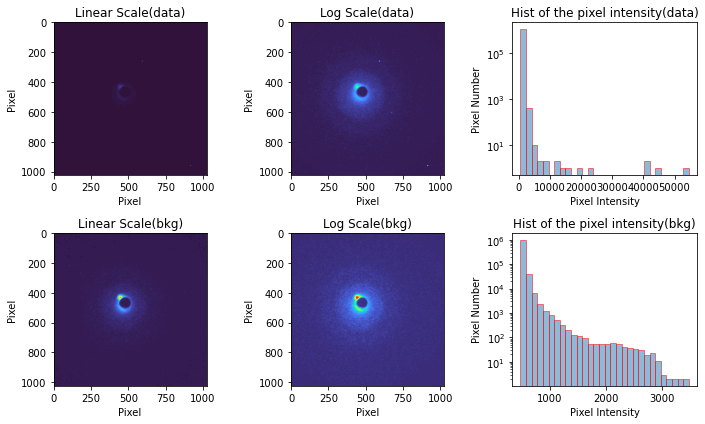

In [38]:
test=tf.imread(files[0]);
bkg_sign='Yes'
print('Load a image to check the signal level: '+files[0]);
print('Total number of images in the chosen directory is ' + str(len(files)));

# Load or not load the bkg signal
if bkg_sign == 'Yes':
    print('Load background signal');
    data_bkg, _, _, _ = get_image_details(bkg_files) # Load bkg images
    test_bkg = tf.imread(bkg_files[0])
    bkg_dlys_ave = np.nanmean(data_bkg,axis=0) # averaging all the images to optain one image

# Plot a testing figure and check the intensity
plt.figure(figsize=(10,6))

if bkg_sign == 'Yes': # Plot both the data and the background images
    plt.subplot(2,3,1);
    plt.imshow(test,cmap='turbo');
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Linear Scale(data)')
    
    plt.subplot(2,3,2);
    plt.imshow(np.log(test),cmap='turbo');
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Log Scale(data)')
    
    plt.subplot(2,3,3);
    plt.hist(test.reshape(-1),bins=30,edgecolor="r",histtype="bar",alpha=0.5)
    plt.xlabel('Pixel Intensity');
    plt.ylabel('Pixel Number');
    plt.title('Hist of the pixel intensity(data)');
    plt.yscale('log')
    
    plt.subplot(2,3,4);
    plt.imshow(test_bkg,cmap='turbo');
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Linear Scale(bkg)')
    
    plt.subplot(2,3,5);
    plt.imshow(np.log(test_bkg),cmap='turbo');
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Log Scale(bkg)')
    
    plt.subplot(2,3,6);
    plt.hist(test_bkg.reshape(-1),bins=30,edgecolor="r",histtype="bar",alpha=0.5)
    plt.xlabel('Pixel Intensity');
    plt.ylabel('Pixel Number');
    plt.title('Hist of the pixel intensity(bkg)');
    plt.yscale('log')
    
else:
    plt.subplot(1,3,1);
    plt.imshow(test,cmap='jet');
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Linear Scale(data)')
    
    plt.subplot(1,3,2);
    plt.imshow(np.log(test),cmap='jet');
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Log Scale(data)')
    
    plt.subplot(1,3,3);
    plt.hist(test.reshape(-1),bins=30,edgecolor="r",histtype="bar",alpha=0.5)
    plt.xlabel('Pixel Intensity');
    plt.ylabel('Pixel Number');
    plt.title('Hist of the pixel intensity(data)');
    plt.yscale('log')
plt.tight_layout()
plt.show()

tf.imwrite("Raw_data_ex.tif", test)

Background from experiment is causing negative values or 0 values.

### Reading in All Data and Getting Total Counts -- Lauren's Version

In [39]:
%%time

highvalue = 50000 # The highest value of pixel intensity from the histogram plot
posi_0    = 108.62 # The reference T0
print('Load diffraction signal');
test_data, stage_positions, file_numbers, counts = get_image_details(files)
counts_mean = np.mean(counts)        # Mean values of Total Counts of all images
counts_std  = np.std(counts)         # the STD of all the tc for all the iamges
uni_stage = np.unique(stage_positions)# Pump-probe stage position

print('Image number read: ', len(counts))
print('Stage positions: ', len(uni_stage))


Load diffraction signal
Image number read:  1998
Stage positions:  37
CPU times: user 2.2 s, sys: 1.64 s, total: 3.85 s
Wall time: 4.79 s


### Visualizing Data Info

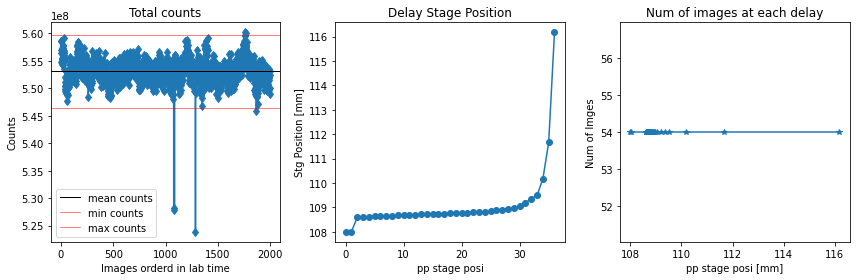

In [40]:
fig = plt.figure(figsize = (12,4)) # Plot counts rate, images number at each posi, and bad images

plt.subplot(1,3,1)
plt.plot(counts,'-d')
plt.axhline(y = counts_mean, color = 'k', linestyle = '-',linewidth=1, label="mean counts");
plt.axhline(y = counts_mean-(3*counts_std), color = 'r', linestyle = '-',linewidth=0.5, label="min counts");
plt.axhline(y = counts_mean+(3*counts_std), color = 'r', linestyle = '-',linewidth=0.5, label="max counts");
plt.xlabel('Images orderd in lab time');
plt.ylabel('Counts');
plt.legend()
plt.title('Total counts');

plt.subplot(1,3,2) # Histogram the number of images at each posi
plt.plot(uni_stage,'-o');
plt.xlabel('pp stage posi');
plt.ylabel('Stg Position [mm]');
plt.title('Delay Stage Position');

plt.subplot(1,3,3) # Histogram the number of images at each posi
posi_edges_bins = np.append(uni_stage-0.001,uni_stage[-1])
posi_hist,posi_edges = np.histogram(stage_positions,bins=posi_edges_bins)
plt.plot(uni_stage,posi_hist,'-*')
plt.xlabel('pp stage posi [mm]');
plt.ylabel('Num of Imges');
plt.title('Num of images at each delay');

plt.tight_layout()
plt.show()

## Filtering Out Bad Shots Based on Total Counts

Either remove shots based on the standard deviation of the total counts or manually select which files to remove based on the image number.  
Based on location of "good" shots. 

In [41]:
# Decide to use threshold or selected images
remove_std = True 
if remove_std is True:
    # Auto find out the bad images by filtering on the total counts
    tc_good = np.squeeze(np.where(abs(counts-counts_mean)<3*counts_std)) # Find out the indices of the low counts images
    good_data = test_data[tc_good]
    good_stage = stage_positions[tc_good]
    good_counts = counts[tc_good]
else:
    # Manual find out the bad images by checking the tc from last figure
    tc_good = np.concatenate((np.arange(0, 923, 1), np.arange(926, 1319, 1), np.arange(1322, 2113, 1), np.arange(2261, len(test_data), 1)))
    good_data=test_data[tc_good]
    good_stage = np.squeeze(stage_positions[tc_good])
    good_counts = counts[tc_good]

print(len(good_data))

1992


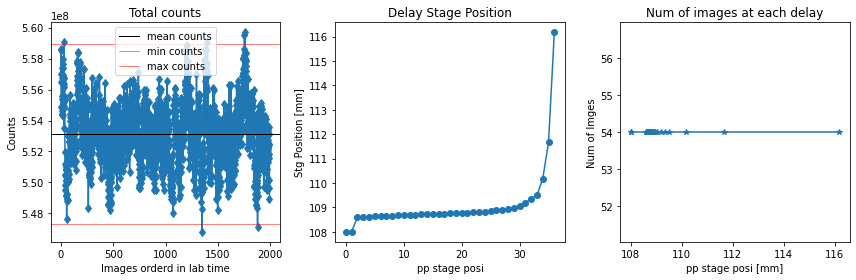

In [42]:
counts_mean = np.mean(good_counts)
counts_std = np.std(good_counts)

fig = plt.figure(figsize = (12,4)) # Plot counts rate, images number at each posi, and bad images

plt.subplot(1,3,1)
plt.plot(good_counts,'-d')
plt.axhline(y = counts_mean, color = 'k', linestyle = '-',linewidth=1, label="mean counts");
plt.axhline(y = counts_mean-(3*counts_std), color = 'r', linestyle = '-',linewidth=0.5, label="min counts");
plt.axhline(y = counts_mean+(3*counts_std), color = 'r', linestyle = '-',linewidth=0.5, label="max counts");
plt.xlabel('Images orderd in lab time');
plt.ylabel('Counts');
plt.legend()
plt.title('Total counts');

plt.subplot(1,3,2) # Histogram the number of images at each posi
plt.plot(uni_stage,'-o');
plt.xlabel('pp stage posi');
plt.ylabel('Stg Position [mm]');
plt.title('Delay Stage Position');

plt.subplot(1,3,3) # Histogram the number of images at each posi
posi_edges_bins = np.append(uni_stage-0.001,uni_stage[-1])
posi_hist,posi_edges = np.histogram(stage_positions,bins=posi_edges_bins)
plt.plot(uni_stage,posi_hist,'-*')
plt.xlabel('pp stage posi [mm]');
plt.ylabel('Num of Imges');
plt.title('Num of images at each delay');

plt.tight_layout()
plt.show()

## Generate Background Based on Corners

Instead of subtracting background images, the function `backgroundNoise` generates a background based on the corners of the `mean_data` and then subtracts this generated background from all the data

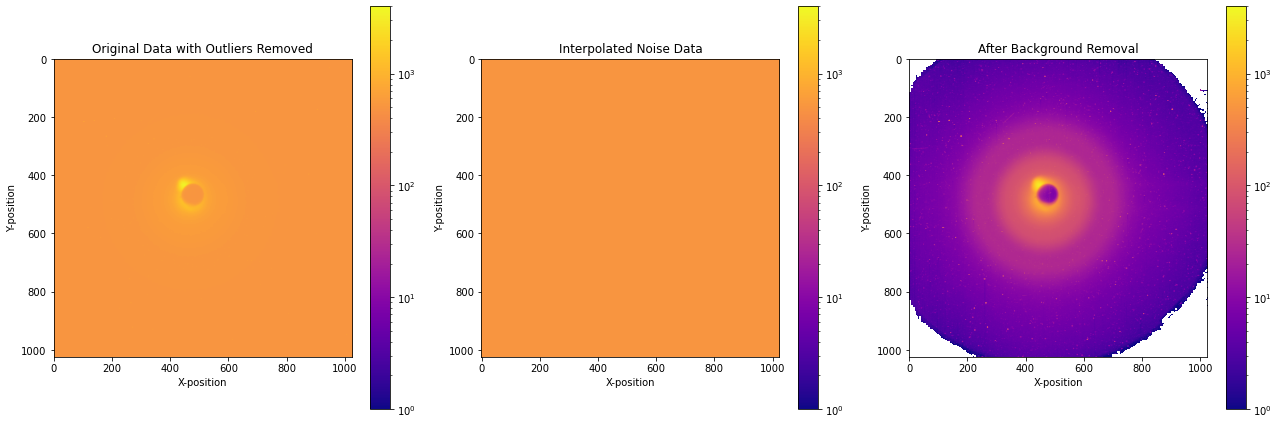

In [59]:
mean_data = np.mean(test, axis = 0)
std_data = np.std(test, axis = 0)

noise_data = backgroundNoise(mean_data)
noiseless_data = backgroundNoise(mean_data, remove_noise = True)

if bkg_sign=='no':
    good_data = good_data - noise_data

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
vmin_1_1, vmax_1_1 = 10**-0, 4000 

#Before
img1 = axes[0].imshow(mean_data, cmap='plasma', norm=matplotlib.colors.LogNorm(vmin=vmin_1_1, vmax=vmax_1_1))
axes[0].set_title('Original Data with Outliers Removed')
axes[0].set_xlabel('X-position')
axes[0].set_ylabel('Y-position')
colorbar1 = fig.colorbar(img1, ax=axes[0])  # Add colorbar to the first subplot

#Noise
img2 = axes[1].imshow(noise_data, cmap='plasma',  norm=matplotlib.colors.LogNorm(vmin=vmin_1_1, vmax=vmax_1_1))  # Use the same normalization as img1
axes[1].set_title('Interpolated Noise Data')
axes[1].set_xlabel('X-position')
axes[1].set_ylabel('Y-position')
colorbar2 = fig.colorbar(img2, ax=axes[1])  # Add colorbar to the second subplot

# Noise Removed
img4 = axes[2].imshow(noiseless_data, cmap='plasma',  norm=matplotlib.colors.LogNorm(vmin=vmin_1_1, vmax=vmax_1_1))  # Logarithmic scaling
axes[2].set_title('After Background Removal')
axes[2].set_xlabel('X-position')
axes[2].set_ylabel('Y-position')
colorbar4 = fig.colorbar(img4, ax=axes[2])  # Add colorbar to the third subplot



# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

## Removing Hot Pixels -- Runs in Parallel

Runs a function called rmv_xrays_all which takes in a 3D data set of N x 1024 x 1024. Running this function runs a different function in parallel which inspects each pixel of each image and compares it against an upper threshhold of 4 standard deviations away from the mean. This function requires global variables `mean_data` and `std_data` of the data. Returns a 3D data set of the same size as the input where outliers are masked using the `numpy.ma.masked_greater_equal()` function. When finished it plots an image of the percent pixels removed for each image 

Removing xrays from all data
(1992, 1024, 1024)


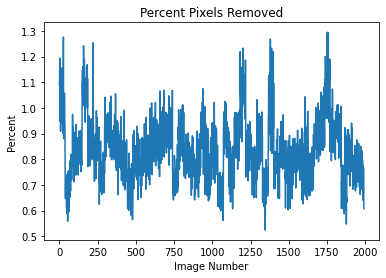

CPU times: user 14.1 s, sys: 9.6 s, total: 23.7 s
Wall time: 26.3 s


In [60]:
%%time
test = good_data
mean_data = np.mean(test, axis = 0)
std_data = np.std(test, axis = 0)
no_xrays = rmv_xrays_all(test)

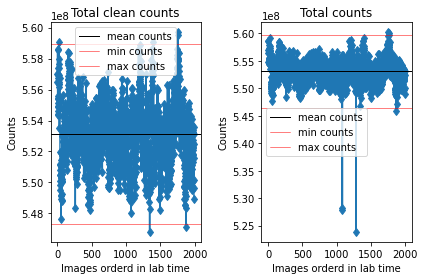

In [44]:
counts_no_xrays= get_counts(no_xrays)

counts_xray_mean = np.mean(counts_no_xrays)
counts_xray_std = np.std(counts_no_xrays)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(counts_no_xrays,'-d')
plt.axhline(y = counts_xray_mean, color = 'k', linestyle = '-',linewidth=1, label="mean counts");
plt.axhline(y = counts_xray_mean-(3*counts_xray_std), color = 'r', linestyle = '-',linewidth=0.5, label="min counts");
plt.axhline(y = counts_xray_mean+(3*counts_xray_std), color = 'r', linestyle = '-',linewidth=0.5, label="max counts");
plt.xlabel('Images orderd in lab time');
plt.ylabel('Counts');
plt.legend()
plt.title('Total clean counts');

plt.subplot(1, 2, 2)
plt.plot(counts,'-d')
plt.axhline(y = np.mean(counts), color = 'k', linestyle = '-',linewidth=1, label="mean counts");
plt.axhline(y = counts_mean-(3*np.std(counts)), color = 'r', linestyle = '-',linewidth=0.5, label="min counts");
plt.axhline(y = counts_mean+(3*np.std(counts)), color = 'r', linestyle = '-',linewidth=0.5, label="max counts");
plt.xlabel('Images orderd in lab time');
plt.ylabel('Counts');
plt.legend()
plt.title('Total counts')     
plt.tight_layout()
plt.show()

good_data = no_xrays
del no_xrays

## Averaging Based on Delay Position

In [45]:
good_data.shape

(1992, 1024, 1024)

In [46]:
%%time
stage_len = len(uni_stage);               #  Number of delays
stage_ave = np.ones((stage_len,1024,1024)); #  Delay dependent averaged pp images
stage_ave_mk = np.ones((stage_len,1024,1024)); #  Delay dependent averaged pp images with mask

if stage_len>20:
    prt_count = 5
else:
    prt_count = 1  
for i in range(stage_len):
    if i%prt_count == 0:
        print('Averaging data at stage posi # '+ str(i) + ', ' + str(uni_stage[i]) + ' mm') # Obtain a sub array to save the data in one delay
    stage_data = good_data[np.where(good_stage==uni_stage[i])[0]];
    if bkg_sign == 'Yes':
        stage_ave[i] = np.nanmean(stage_data,axis=0) - bkg_dlys_ave; # subtracting the background
    else:
        stage_ave[i] = np.nanmean(stage_data,axis=0); # no subtracting background
    stage_ave[i][stage_ave[i]<0] = 0; # make negative values to 0 
    


Averaging data at stage posi # 0, 108.0 mm
Averaging data at stage posi # 5, 108.63 mm
Averaging data at stage posi # 10, 108.68 mm
Averaging data at stage posi # 15, 108.73 mm
Averaging data at stage posi # 20, 108.78 mm
Averaging data at stage posi # 25, 108.85 mm
Averaging data at stage posi # 30, 109.05 mm
Averaging data at stage posi # 35, 111.67 mm
CPU times: user 1.8 s, sys: 499 ms, total: 2.3 s
Wall time: 2.3 s


## Masking Beam Block

Uses `opencv.HoughCircles` to find the circular mask on the image.  
We use the function: cv.HoughCircles (image, circles, method, dp, minDist, param1 = 100, param2 = 100, minRadius = 0, maxRadius = 0)

__Parameters:__
 - `image` 8-bit, single-channel, grayscale input image.
 - `circles` output vector of found circles(cv.CV_32FC3 type). Each vector is encoded as a 3-element floating-point vector (x,y,radius) .
 - `method` detection method(see cv.HoughModes). Currently, the only implemented method is HOUGH_GRADIENT
 - `dp` inverse ratio of the accumulator resolution to the image resolution. For example, if dp = 1 , the accumulator has the same resolution as the input image. If dp = 2 , the accumulator has half as big width and height.
 - `minDist` minimum distance between the centers of the detected circles. If the parameter is too small, multiple neighbor circles may be falsely detected in addition to a true one. If it is too large, some circles may be missed.
 - `param1` first method-specific parameter. In case of HOUGH_GRADIENT , it is the higher threshold of the two passed to the Canny edge detector (the lower one is twice smaller).
 - `param2` second method-specific parameter. In case of HOUGH_GRADIENT , it is the accumulator threshold for the circle centers at the detection stage. The smaller it is, the more false circles may be detected. Circles, corresponding to the larger accumulator values, will be returned first.
 - `minRadiu` minimum circle radius.
 - `maxRadius` maximum circle radius.

__Note:__ only works after averaging for each stage position. Too large of data sets causes jupyter to crash. Will trouble shoot this later...

In [47]:
# (1) Hole mask: Define mask of the hole
data_ave_raw = np.mean(good_data,axis=0); # Mean data of all the images
data_ave     = np.copy(data_ave_raw) #[200:900,200:900]
image_array  = np.log(data_ave)/np.nanmax(np.log(data_ave))
image_array  *=255
im = Image.fromarray(image_array)
im = im.convert('L')
im = np.array(im)

# Mask hole and Finding the diffraction center
hole = np.squeeze(cv2.HoughCircles(im, cv2.HOUGH_GRADIENT_ALT, 1.5, 32, param1=50, param2=0.9, minRadius=30, maxRadius=60))
mask = np.ones((1024,1024)) # Hole mask
y_m,x_m = np.ogrid[:1024,:1024];
mask[((x_m-hole[0])**2 + (y_m-hole[1])**2 <= (hole[2]+5)**2)] = np.nan;# Create a circular mask filled with nans inside the circle
print('The hole center at ' + str(hole[0:2]) + ' with radius ' + str(hole[2:3]));
stage_ave = stage_ave*mask

The hole center at [477.  466.5] with radius [37.99316]


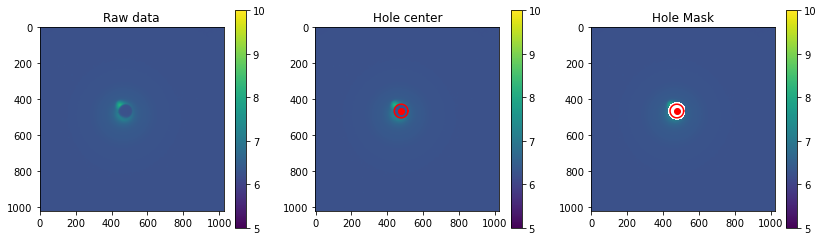

In [48]:
theta = np.linspace(0, 2 * np.pi, 200)
x = np.cos(theta)*hole[2]+hole[0];
y = np.sin(theta)*hole[2]+hole[1];

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.imshow(np.log(data_ave_raw));
plt.colorbar();
plt.clim([5,10]);
plt.title('Raw data')

plt.subplot(1,3,2)
plt.imshow(np.log(data_ave_raw));
plt.colorbar()
plt.plot(x,y,'r',hole[0],hole[1],'or');
plt.clim([5,10]);
plt.title('Hole center');

plt.subplot(1,3,3)
plt.imshow(np.log(data_ave_raw*mask));
plt.colorbar();
plt.plot(x,y,'r',hole[0],hole[1],'or');
plt.clim([5,10]);
plt.title('Hole Mask');
plt.show()

### Caidan's Version -- Use for additional masks?

(37, 1024, 1024)


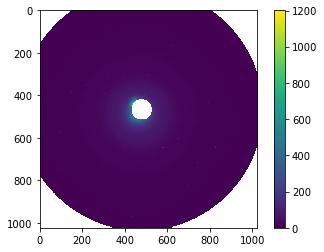

In [23]:
hole_center = (477.0, 466.5)
inner_radius = 43
outer_radius = 575
data_ave_raw = np.mean(good_data,axis=0); 
ring_mask_data = detectorMask(stage_ave, hole_center, inner_radius, outer_radius, plot_image = True)
ring_mask_ave = np.mean(ring_mask_data, axis = 0)
print(ring_mask_data.shape)

<ipython-input-24-95d0f20c1abd>:8: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.mean(stage_ave, axis=0)));
<ipython-input-24-95d0f20c1abd>:21: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(ring_mask_ave));


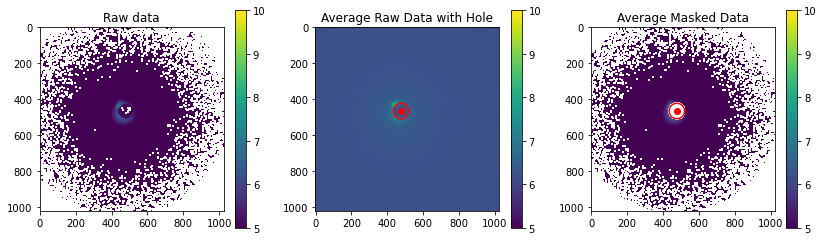

In [24]:
theta = np.linspace(0, 2 * np.pi, 200)
x = np.cos(theta)*inner_radius+hole_center[0];
y = np.sin(theta)*inner_radius+hole_center[1];

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.imshow(np.log(np.mean(stage_ave, axis=0)));
plt.colorbar();
plt.clim([5,10]);
plt.title('Raw data')

plt.subplot(1,3,2)
plt.imshow(np.log(data_ave_raw));
plt.colorbar()
plt.plot(x,y,'r',hole_center[0],hole_center[1],'or');
plt.clim([5,10]);
plt.title('Average Raw Data with Hole');

plt.subplot(1,3,3)
plt.imshow(np.log(ring_mask_ave));
plt.colorbar();
plt.plot(x,y,'r',hole_center[0],hole_center[1],'or');
plt.clim([5,10]);
plt.title('Average Masked Data');
plt.show()

## Finding Diffraction Center

Right now it is only worthwhile to run this on the stage averaged data as it takes a very long time. Ultimately will try to get working in parallel in order to find the center of each individual image. __Note:__ occasionally it returns a 0, 0 value for the centers. The average of all non-zero values are taken and then each zero is replaced with the average center. 

In [49]:
%%time

x_centers = []
y_centers = []
for i in range(len(stage_ave)):
    center = find_beam_center(stage_ave[i])
    x_centers.append(center[0])
    y_centers.append(center[1])
    if i%2 == 0:
        print('Found center of ' + str(center)+' stage_position ' + str(uni_stage[i]))
x_centers = np.array(x_centers)
y_centers = np.array(y_centers)
centers = x_centers, y_centers
x_ave = np.mean(x_centers[np.where(x_centers > 0)[0]])
y_ave = np.mean(y_centers[np.where(y_centers > 0)[0]])
x_centers[np.where(x_centers == 0)[0]] = x_ave
y_centers[np.where(y_centers == 0)[0]] = y_ave
center_ave = x_ave, y_ave
print(r'Averaged ctr is ' + str(center_ave))

Found center of [0, 0] stage_position 108.0
Found center of [0, 0] stage_position 108.6
Found center of [0, 0] stage_position 108.62
Found center of [0, 0] stage_position 108.64
Found center of [488, 464] stage_position 108.66
Found center of [487, 461] stage_position 108.68
Found center of [0, 0] stage_position 108.7
Found center of [0, 0] stage_position 108.72
Found center of [0, 0] stage_position 108.74
Found center of [0, 0] stage_position 108.76
Found center of [0, 0] stage_position 108.78
Found center of [0, 0] stage_position 108.8
Found center of [488, 462] stage_position 108.82
Found center of [489, 463] stage_position 108.88
Found center of [0, 0] stage_position 108.94
Found center of [491, 461] stage_position 109.05
Found center of [491, 462] stage_position 109.35
Found center of [489, 463] stage_position 110.17
Found center of [488, 464] stage_position 116.17
Averaged ctr is (489.47058823529414, 463.29411764705884)
CPU times: user 1.51 s, sys: 2.02 s, total: 3.52 s
Wall time

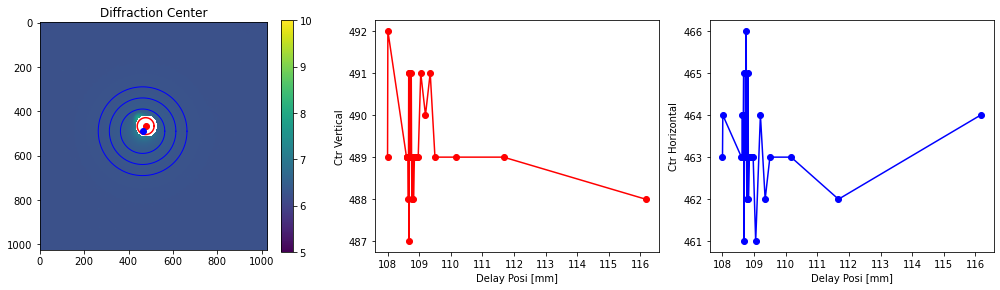

In [50]:
theta = np.linspace(0, 2 * np.pi, 200)
x = np.cos(theta)*hole[2]+hole[0];
y = np.sin(theta)*hole[2]+hole[1];
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.imshow(np.log(np.mean(good_data, axis=0)*mask));
plt.colorbar()
plt.plot(x,y,'r',hole[0],hole[1],'or',center_ave[1],center_ave[0],'ob');
for i in range(3):
    x = np.cos(theta)*(i+2)*50+center_ave[1];
    y = np.sin(theta)*(i+2)*50+center_ave[0];
    plt.plot(x,y,linewidth=1,color='b');
plt.clim([5,10]);
plt.title('Diffraction Center')

plt.subplot(1,3,2)
plt.plot(uni_stage, centers[0],'-or');
plt.xlabel('Delay Posi [mm]');
plt.ylabel('Ctr Vertical');

plt.subplot(1,3,3)
plt.plot(uni_stage, centers[1],'-ob');
plt.xlabel('Delay Posi [mm]');
plt.ylabel('Ctr Horizontal');

plt.tight_layout()
plt.show();

## Removing Radial Outliers -- BETA (still testing)

Runs the function `remove_radial_outliers` which takes in a 1024, 1024 image and generates the radial average of that image. Then it compares each point at that radial distance with the mean to a threshhold value of 3 standard deviations from the mean. If the pixel value falls outside of the threshhold range, the average radial value is swapped in. 

__Notes:__ 
 - Requires global variables of `X_CENTER`, `Y_CENTER`, and `GRID_SIZE` 
 - Currently runs very slowly. Will work on running it in parallel eventually
 - Try starting radial values at 1 instead of zero to remove runtime warning
 - Need to add additional mask eventually as this exaggerates bright spot in the data

In [24]:
%%time
stage_ave = np.nan_to_num(stage_ave)
X_CENTER = center_ave[0]
Y_CENTER = center_ave[1]
GRID_SIZE = 1024
azi_data = []
for image in stage_ave:
    data, _ = get_radial_distribution(image) # Function of averaging
    azi_data.append(data)
    
    
azi_data = np.array(azi_data)
print(azi_data.shape)

cleaned_data = []
for image in stage_ave:
    clean_image = remove_radial_outliers(image)
    cleaned_data.append(clean_image)

cleaned_data = np.array(cleaned_data)
print(cleaned_data.shape)

<ipython-input-6-5062480ba19f>:91: RuntimeWarning: Mean of empty slice
  average = np.nanmean(array)
/home/centurion/lheald2/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


KeyboardInterrupt: 

<ipython-input-23-db43e01e60ef>:6: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(stage_ave[0]))
<ipython-input-23-db43e01e60ef>:10: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(cleaned_data[0]))


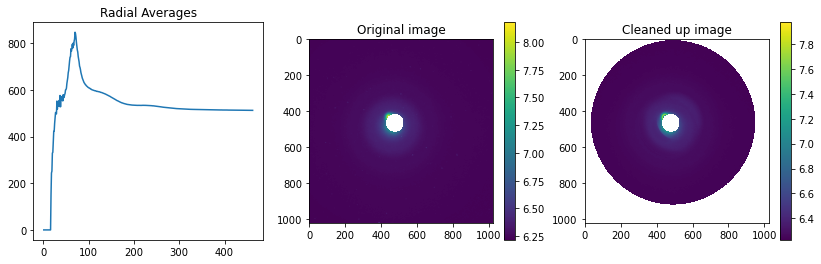

In [23]:
plt.figure(figsize=(14,4))
plt.subplot(1, 3, 1)
plt.plot(azi_data[0])
plt.title("Radial Averages")
plt.subplot(1, 3, 2)
plt.imshow(np.log(stage_ave[0]))
plt.colorbar()
plt.title("Original image")
plt.subplot(1,3,3)
plt.imshow(np.log(cleaned_data[0]))
plt.colorbar()
plt.title("Cleaned up image")
plt.show()

## Median Filtering -- BETA

Imports a data array of n x 1024 x 1024 and applies the `scipy.ndimage.median_filter()` function to each. Requires a set grid size, currently set to 5. 

In [19]:
%%time
test = stage_ave
#mean_data = np.mean(test, axis = 0)
#std_data = np.std(test, axis = 0)
#test_no_xrays = rmv_xrays_all(test)
clean_data_all = clean_all(test)

Cleaning all data with concurrent.futures.ProcessPoolExecutor
(37, 1024, 1024)
Finished cleaning!!
CPU times: user 202 ms, sys: 554 ms, total: 757 ms
Wall time: 4.1 s


<ipython-input-28-d0212ebd73ec>:4: RuntimeWarning: Mean of empty slice
  counts_clean_mean = np.nanmean(counts_clean_all)
/home/centurion/lheald2/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-28-d0212ebd73ec>:19: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(stage_ave[0]))


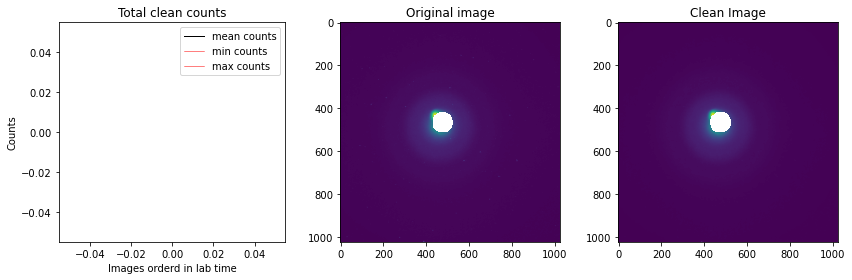

In [28]:
stage_ave = np.nan_to_num(stage_ave)
counts_clean_all = get_counts(clean_data_all)

counts_clean_mean = np.nanmean(counts_clean_all)
counts_clean_std = np.nanstd(counts_clean_all)

plt.figure(figsize = (12,4))
plt.subplot(1, 3, 1)
plt.plot(counts_clean_all,'-d')
plt.axhline(y = counts_clean_mean, color = 'k', linestyle = '-',linewidth=1, label="mean counts");
plt.axhline(y = counts_clean_mean-(3*counts_clean_std), color = 'r', linestyle = '-',linewidth=0.5, label="min counts");
plt.axhline(y = counts_clean_mean+(3*counts_clean_std), color = 'r', linestyle = '-',linewidth=0.5, label="max counts");
plt.xlabel('Images orderd in lab time');
plt.ylabel('Counts');
plt.legend()
plt.title('Total clean counts');

plt.subplot(1, 3, 2)
plt.imshow(np.log(stage_ave[0]))
plt.title("Original image")

plt.subplot(1, 3, 3)
plt.imshow(np.log(clean_data_all[0]))
plt.title("Clean Image")
plt.tight_layout()
plt.show()

### Benchmarking Parallel Processing -- Don't run

In [99]:
%%time 
# Benchmarking above without parallel
#xray_clean = cleanMean(test)
clean_data = clean_and_filter(test)

clean_data = np.array(clean_data)
print(clean_data.shape)

Cleaning data


KeyboardInterrupt: 

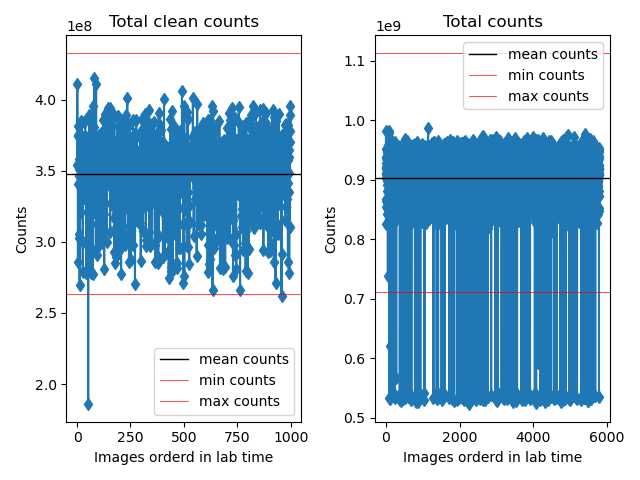

In [43]:
counts_clean = get_counts(clean_data)

counts_clean_mean = np.mean(counts_clean)
counts_clean_std = np.std(counts_clean)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(counts_clean,'-d')
plt.axhline(y = counts_clean_mean, color = 'k', linestyle = '-',linewidth=1, label="mean counts");
plt.axhline(y = counts_clean_mean-(3*counts_clean_std), color = 'r', linestyle = '-',linewidth=0.5, label="min counts");
plt.axhline(y = counts_clean_mean+(3*counts_clean_std), color = 'r', linestyle = '-',linewidth=0.5, label="max counts");
plt.xlabel('Images orderd in lab time');
plt.ylabel('Counts');
plt.legend()
plt.title('Total clean counts');

plt.subplot(1, 2, 2)
plt.plot(counts,'-d')
plt.axhline(y = np.mean(counts), color = 'k', linestyle = '-',linewidth=1, label="mean counts");
plt.axhline(y = counts_mean-(3*np.std(counts)), color = 'r', linestyle = '-',linewidth=0.5, label="min counts");
plt.axhline(y = counts_mean+(3*np.std(counts)), color = 'r', linestyle = '-',linewidth=0.5, label="max counts");
plt.xlabel('Images orderd in lab time');
plt.ylabel('Counts');
plt.legend()
plt.title('Total counts')     
plt.tight_layout()
plt.show()

## Clean After Averaging

Here, we utilize a masked array to create nan values for each entry outside of the standard deviation threshold. In this way, we eliminate the need for inputting NaN values, as these are stored as a Boolean.

In [19]:
%%time

#clean_data = cleanMean(test_data)
#counts_clean = get_counts(clean_data)
clean_data = clean_and_filter(stage_ave)
clean_data = np.array(clean_data)
counts_clean = get_counts(clean_data)

counts_clean_mean = np.mean(counts_clean)
counts_clean_std = np.std(counts_clean)

Cleaning data
CPU times: user 23.7 s, sys: 0 ns, total: 23.7 s
Wall time: 23.8 s


<ipython-input-20-e0a8f3a6babb>:23: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(clean_data[0]));
<ipython-input-20-e0a8f3a6babb>:23: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(clean_data[0]));


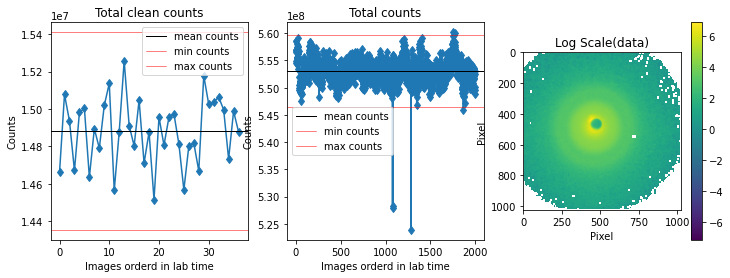

In [20]:
fig = plt.figure(figsize = (12,4))
plt.subplot(1, 3, 1)
plt.plot(counts_clean,'-d')
plt.axhline(y = counts_clean_mean, color = 'k', linestyle = '-',linewidth=1, label="mean counts");
plt.axhline(y = counts_clean_mean-(3*counts_clean_std), color = 'r', linestyle = '-',linewidth=0.5, label="min counts");
plt.axhline(y = counts_clean_mean+(3*counts_clean_std), color = 'r', linestyle = '-',linewidth=0.5, label="max counts");
plt.xlabel('Images orderd in lab time');
plt.ylabel('Counts');
plt.legend()
plt.title('Total clean counts');

plt.subplot(1, 3, 2)
plt.plot(counts,'-d')
plt.axhline(y = np.mean(counts), color = 'k', linestyle = '-',linewidth=1, label="mean counts");
plt.axhline(y = counts_mean-(3*np.std(counts)), color = 'r', linestyle = '-',linewidth=0.5, label="min counts");
plt.axhline(y = counts_mean+(3*np.std(counts)), color = 'r', linestyle = '-',linewidth=0.5, label="max counts");
plt.xlabel('Images orderd in lab time');
plt.ylabel('Counts');
plt.legend()
plt.title('Total counts')

plt.subplot(1, 3, 3)
plt.imshow(np.log(clean_data[0]));
plt.colorbar()
plt.xlabel('Pixel');
plt.ylabel('Pixel');
plt.title('Log Scale(data)')

plt.show()

Kind of confused on how cv2.HoughCircles works... This block only makes the mask. It is applied when centers are found

Runs based on an array of positions based on x and y values. Throws runtime warnings and for some reason doesn't work on the average of the masked data. Gives array of all zeros

## Radially Averaging -- Marty's Way vs SLAC Way

<ipython-input-6-5062480ba19f>:91: RuntimeWarning: Mean of empty slice
  average = np.nanmean(array)
/home/centurion/lheald2/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(1, 462)
max Q index is 462


<ipython-input-6-5062480ba19f>:62: RuntimeWarning: Mean of empty slice
  ave=np.nanmean(I_r)
<ipython-input-6-5062480ba19f>:65: RuntimeWarning: Mean of empty slice
  I[ri]=np.nanmean(I_r)


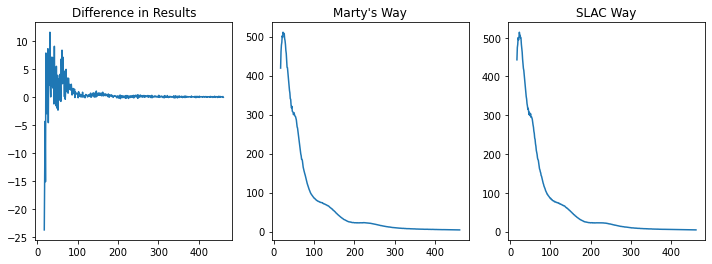

CPU times: user 4.09 s, sys: 1.39 ms, total: 4.09 s
Wall time: 4.1 s


In [51]:
%%time

# Azimuthally averaging on the data at each delays
X_CENTER = 488
Y_CENTER = 462
GRID_SIZE = 1024
azi_data = []

data, _ = get_radial_distribution(stage_ave[2]) # Function of averaging
azi_data.append(data)
    
    
azi_data = np.array(azi_data)
print(azi_data.shape)

pointer = np.empty((1024,1024))
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        pointer[i,j]=int(np.sqrt((i-X_CENTER)**2+(j-Y_CENTER)**2))
img_r_max = int(min(X_CENTER, Y_CENTER, GRID_SIZE-X_CENTER, GRID_SIZE-Y_CENTER))
x=[];y=[]
for ri in range(img_r_max):
    [X_temp,Y_temp]=np.where(pointer==ri)
    x.append(X_temp)
    y.append(Y_temp)
print(r'max Q index is ' + str(img_r_max));
r_max=len(x)

azi_data_slac = azimuthal_avg_correct((stage_ave[2], x, y));

plt.figure(figsize = (12,4))
plt.subplot(1,3,1)
plt.plot(azi_data[0]-azi_data_slac)
plt.title("Difference in Results")

plt.subplot(1,3,2)
plt.plot(azi_data[0])
plt.title("Marty's Way")

plt.subplot(1,3,3)
plt.plot(azi_data_slac)
plt.title("SLAC Way")
plt.show()

## Radial Averaging -- SLAC Way

In [52]:
X_CENTER = center_ave[0]
Y_CENTER = center_ave[1]
GRID_SIZE = 1024

pointer = np.empty((1024,1024))
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        pointer[i,j]=int(np.sqrt((i-X_CENTER)**2+(j-Y_CENTER)**2))
img_r_max = int(min(X_CENTER, Y_CENTER, GRID_SIZE-X_CENTER, GRID_SIZE-Y_CENTER))
x=[];y=[]
for ri in range(img_r_max):
    [X_temp,Y_temp]=np.where(pointer==ri)
    x.append(X_temp)
    y.append(Y_temp)
print(r'max Q index is ' + str(img_r_max));
r_max=len(x)

azi_slac = get_azimuthal_average(stage_ave, x, y)

max Q index is 463


<ipython-input-6-5062480ba19f>:62: RuntimeWarning: Mean of empty slice
  ave=np.nanmean(I_r)
/home/centurion/lheald2/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-6-5062480ba19f>:65: RuntimeWarning: Mean of empty slice
  I[ri]=np.nanmean(I_r)


## Normalize Radial Averages to Baseline

Confused about the point of this...

<ipython-input-27-67fd8adb23d3>:242: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data, axis=0)


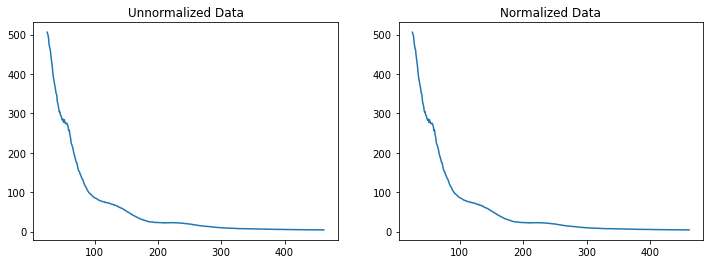

In [53]:
norm_data = normalize_to_baseline(azi_slac) 

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(azi_slac[0])
plt.title("Unnormalized Data")

plt.subplot(1,2,2)
plt.plot(norm_data[0])
plt.title("Normalized Data")
plt.show()

## Plotting the Time-Dependent Signal

<ipython-input-54-5b1a7d6b78c3>:11: RuntimeWarning: Mean of empty slice
  norm_ref = np.nanmean(norm_data[:N_ref],axis=0);         # Reference signal before T0
<ipython-input-54-5b1a7d6b78c3>:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(s,realtime,dI_I_norm,cmap='bwr');


98


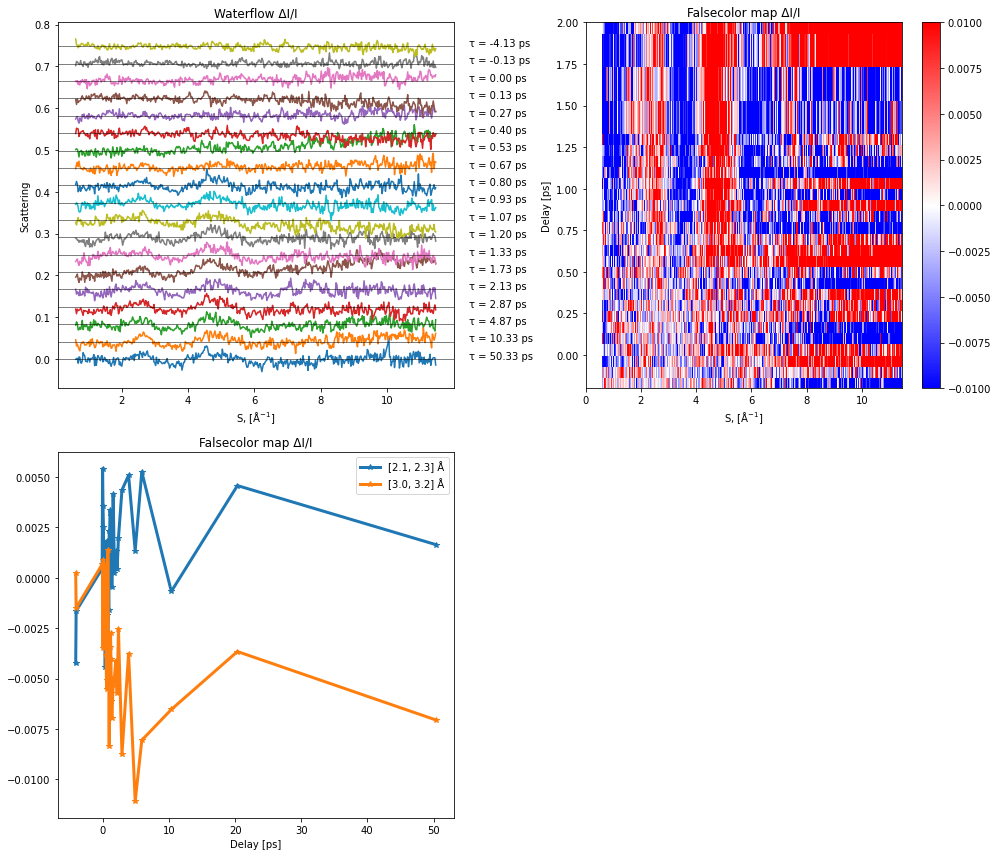

In [54]:
# (3) Plot the figure: Plot the time-dependent signal
angs = '\u00C5'; # angstrom sign
s_cali = 0.0248 # S calibration in experiment
s = np.arange(0,len(azi_slac[0]))*s_cali # The Q axis
realtime = (uni_stage-posi_0)/0.15  # Delay axis in ps

if stage_len<5: # Make up the reference signals
    N_ref = 2
else:
    N_ref = 4
norm_ref = np.nanmean(norm_data[:N_ref],axis=0);         # Reference signal before T0
dI_I_norm = (norm_data-norm_ref)/norm_ref; # Calculate the percentage difference signal

# Plot a figure of the time-depdendent signal of scattering percentage difference.
plt.figure(figsize=(14,12))

plt.subplot(2,2,1)
for i in range(stage_len):
    if i%2 == 0:
        plt.plot(s,dI_I_norm[stage_len-i-1] + np.nanmax(dI_I_norm)*(i)/3);
        plt.text(s[-1]+1,np.nanmax(dI_I_norm)*(i)/3, r'τ = {0:.2f} ps'.format(realtime[stage_len-i-1]))
        plt.axhline(y = np.nanmax(dI_I_norm)*(i)/3, color = 'k', linestyle = '-',linewidth=0.5);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Scattering');plt.title('Waterflow ΔI/I');

plt.subplot(2,2,2)
plt.pcolor(s,realtime,dI_I_norm,cmap='bwr');
plt.clim(vmin=-0.01, vmax=0.01);
plt.colorbar()
plt.ylim(-0.2, 2)
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Delay [ps]');plt.title('Falsecolor map ΔI/I')

plt.subplot(2,2,3)
RoI_1 = [2.1, 2.3];
RoI_2 = [3.0, 3.2];
print(round(RoI_1[0]/0.0215))
Inte_1 = dI_I_norm[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].mean(axis=1);
Inte_2 = dI_I_norm[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].mean(axis=1);
plt.plot(realtime,Inte_1,'-*',linewidth=3,label=str(RoI_1)+' '+angs);
plt.plot(realtime,Inte_2,'-*',linewidth=3,label=str(RoI_2)+' '+angs);
plt.legend()
plt.xlabel('Integrated Yield [arb.]');plt.xlabel('Delay [ps]');plt.title('Falsecolor map ΔI/I')

plt.tight_layout()
plt.show()

# plt.tight_layout()
# plt.show()

## Gaussian Filtering and Baseline Subtraction

<ipython-input-32-134a260ae639>:1: RuntimeWarning: Mean of empty slice
  dI_I_ave = np.nanmean(dI_I_norm, axis=0)


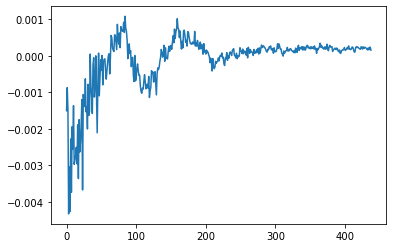

In [32]:
dI_I_ave = np.nanmean(dI_I_norm, axis=0)
dI_I_ave = dI_I_ave[25:]
plt.figure()
plt.plot(dI_I_ave)
plt.show()

No handles with labels found to put in legend.


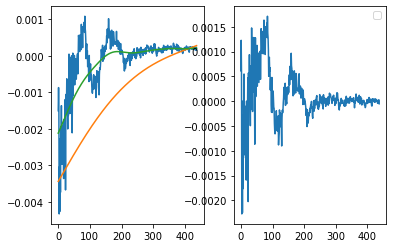

In [33]:


baseline = Baseline(np.arange(len(dI_I_ave)))

lam = 5e6
tol = 1e-3
max_iter = 20
fit_1, params_1 = baseline.asls(dI_I_ave, lam=lam, tol=tol, max_iter=max_iter)
fit_2, params_2 = baseline.aspls(dI_I_ave, lam=lam, tol=tol, max_iter=max_iter)

baseline_corr_ave = dI_I_ave-fit_2
plt.figure()
plt.subplot(1,2,1)
plt.plot(dI_I_ave)
plt.plot(fit_1, label='asls')
plt.plot(fit_2, label='aspls')

plt.subplot(1,2,2)
plt.plot(baseline_corr_ave)
plt.legend()



In [34]:
gf_data = gaussian_filter_2d(dI_I_norm)

<ipython-input-36-6973830060d5>:11: RuntimeWarning: Mean of empty slice
  azi_data_norm_ref = np.nanmean(azi_slac[:N_ref],axis=0);         # Reference signal before T0
<ipython-input-36-6973830060d5>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(s,realtime,gf_data,cmap='bwr');


98


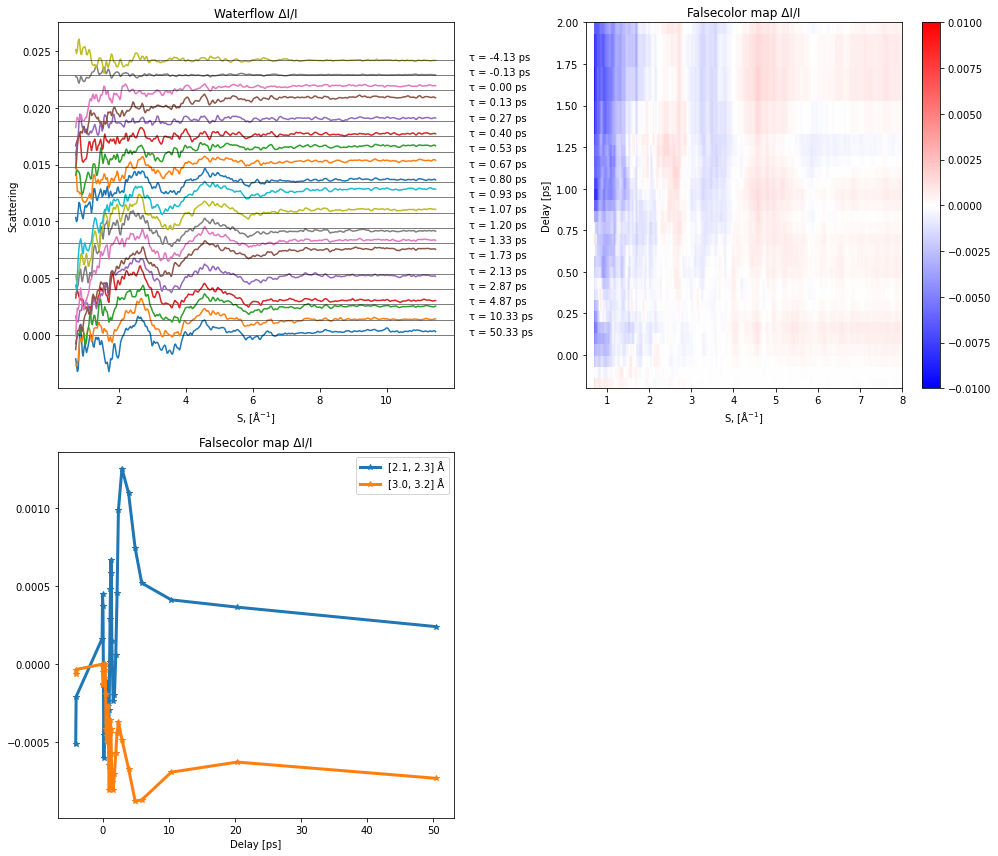

In [36]:
# (3) Plot the figure: Plot the time-dependent signal
angs = '\u00C5'; # angstrom sign
s_cali = 0.0248 # S calibration in experiment
s = np.arange(0,len(azi_slac[0]))*s_cali # The Q axis
realtime = (uni_stage-posi_0)/0.15  # Delay axis in ps

if stage_len<5: # Make up the reference signals
    N_ref = 2
else:
    N_ref = 4
azi_data_norm_ref = np.nanmean(azi_slac[:N_ref],axis=0);         # Reference signal before T0
dI_I_norm = (azi_slac-azi_data_norm_ref)/azi_data_norm_ref; # Calculate the percentage difference signal

# Plot a figure of the time-depdendent signal of scattering percentage difference.
plt.figure(figsize=(14,12))

plt.subplot(2,2,1)
for i in range(stage_len):
    if i%2 == 0:
        plt.plot(s,gf_data[stage_len-i-1] + np.nanmax(gf_data)*(i)/3);
        plt.text(s[-1]+1,np.nanmax(gf_data)*(i)/3, r'τ = {0:.2f} ps'.format(realtime[stage_len-i-1]))
        plt.axhline(y = np.nanmax(gf_data)*(i)/3, color = 'k', linestyle = '-',linewidth=0.5);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');
plt.ylabel('Scattering');
plt.title('Waterflow ΔI/I');

plt.subplot(2,2,2)
plt.pcolor(s,realtime,gf_data,cmap='bwr');
plt.clim(vmin=-0.01, vmax=0.01);
plt.colorbar()
plt.xlim(0.5, 8)
plt.ylim(-0.2, 2)
plt.xlabel(r'S, ['+angs+'$^{-1}$]');
plt.ylabel('Delay [ps]');
plt.title('Falsecolor map ΔI/I')

plt.subplot(2,2,3)
RoI_1 = [2.1, 2.3];
RoI_2 = [3.0, 3.2];
print(round(RoI_1[0]/0.0215))
Inte_1 = gf_data[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].mean(axis=1);
Inte_2 = gf_data[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].mean(axis=1);
plt.plot(realtime,Inte_1,'-*',linewidth=3,label=str(RoI_1)+' '+angs);
plt.plot(realtime,Inte_2,'-*',linewidth=3,label=str(RoI_2)+' '+angs);
plt.legend()
plt.xlabel('Integrated Yield [arb.]');plt.xlabel('Delay [ps]');plt.title('Falsecolor map ΔI/I')

plt.tight_layout()
plt.show()

# plt.tight_layout()
# plt.show()

### Plotting the Time-Dependent Signal

## Plotting 4 Point Scan

# Simulated Data

## Functions

### SLAC Method 

In [ ]:
path_dcs='/sdf/data/lcls/ds/ued_testfac/scratch/gued_online_analysis/jupyter_notebook/user_notebooks/dcs_repository/3.7MeV/'
table=pd.read_csv(path_dcs+'Periodic_Table.csv')
def import_s():
    qe=1.602176565e-19 
    me=9.10938291e-31
    c=299792458 
    h=6.62606957e-34
    E=3700000*qe+me*c**2 #kinetic energy=3.7MeV
    p=(E**2/c**2-me**2*c**2)**0.5
    lamb=h/p
    k=2*np.pi/lamb #wave vector of the incident electron

    path=path_dcs+'C.dat'
    with open(path,'r') as file:
        a=file.read()
    a0=a.split('\n')
    theta_deg=np.empty(130)
    for i in range(130):
        a31=str(a0[31+i]).split(' ')
        theta_deg[i]=a31[2]
    
    theta=theta_deg*np.pi/180
    S=2*k*np.sin(0.5*theta)
    s=np.array(S)
    return s

def read_dat_dcs(atom_no,path_dcs):
    atom_sym=no_to_sym(atom_no)
    path=path_dcs+atom_sym+'.dat'
    with open(path,'r') as file:
        a=file.read()
    a0=a.split('\n')
    data=np.empty(130)
    for i in range(130):
        a31=str(a0[31+i]).split(' ')
        data[i]=a31[6]
    return data**0.5*1e8

def sym_to_no(ele_sym):
    n=np.where(table['Symbol']==ele_sym)
    return int(n[0]+1)

def no_to_sym(ele_no):
    return table['Symbol'][ele_no-1]

def import_DCS(max_at_no):
    f=np.empty((max_at_no+1,130))
    for i in range(max_at_no):
        f[i+1]=read_dat_dcs(i+1,path_dcs)
    return f

### Lauren's Method

In [73]:
 def read_xyz(filename):
    xyz_file = filename
    file = open(xyz_file, 'r')
    text = file.readlines()
    file.close()
    x = []
    y = []
    z = []
    atoms = []
    count = len(text)

    for j in range(0, count):
        try:
            string = list(map(str, text[j].split()))
            atoms.append(string[0])
            x.append(float(string[1]))
            y.append(float(string[2]))
            z.append(float(string[3]))
        except Exception:
            pass
    return atoms, x, y, z

def unique(atoms):
    unique_atoms = []
    for i in range(len(atoms)):
        if atoms[i] not in unique_atoms:
            unique_atoms.append(atoms[i])
    print(unique_atoms)
    return unique_atoms

def atom_index(atoms, unique_atoms):
    idx_all = []
    for i in range(len(atoms)):
        for j in range(len(unique_atoms)):
            if atoms[i] == unique_atoms[j]:
                idx_all.append(j)
    print(idx_all)
    return idx_all

def scat_phas(unique_atoms, Energy):
    Scatamps = []
    phas = []
    for atom in unique_atoms:
        df = pd.read_excel(form_factor_all, atom)
        string = atom + "_ff"
        data = df.to_csv(string, header=None)
        f = open(string,'r')
        ff_lines = f.readlines()[1:]
        f.close()
        s0 = []
        Scat = []
        eta = []
        for i in range(len(ff_lines)):
            string = list(map(str, ff_lines[i].split(",")))
            s0.append(float(string[1]))
            if Energy == 10000: 
                Scat.append(float(string[2]))
                eta.append(float(string[3]))
            elif Energy == 40000:
                Scat.append(float(string[4]))
                eta.append(float(string[5]))
            elif Energy == 60000:
                Scat.append(float(string[6]))
                eta.append(float(string[7]))
            elif Energy == 90000:
                Scat.append(float(string[8]))
                eta.append(float(string[9]))
            else:
                print("not a valid energy")
                break
        Scatamps.append(Scat)
        phas.append(eta)
    for atom in unique_atoms:
        string = atom + "_ff"
        os.remove(string)
    return s0, Scatamps, phas

def get_I_atomic(n, ds, s0, amps, phase, atoms, idx_all):
    I_at_all = []
    for i in range(len(atoms)):
        I_atomic = []
        I_at = 0
        interp_amps = interp.interp1d(s0, amps[idx_all[i]])
        interp_phase = interp.interp1d(s0, phase[idx_all[i]])
        stop = n/2 * ds
        s_new = np.arange(0, stop, ds)
        amps_new = interp_amps(s_new)
        phase_new = interp_phase(s_new)
        for k in range(len(amps_new)):
            f = amps_new[k]
            I_at = np.abs(f)**2
            I_atomic.append(float(I_at))
        I_at_all.append(I_atomic)
    return I_at_all, s_new

def get_I_molecular(atoms, x, y, z, n, ds, s0, amps, phase, idx_all):
    I_mol_all = []
    for i in range(0, len(atoms)):
        for j in range(0, len(atoms)): # Does each atom pair calculation twice
            I_mol = []
            if i == j:
                pass
            else:
                r_ij = (x[i] - x[j]) ** 2 + (y[i] - y[j]) ** 2 + (z[i] - z[j]) ** 2
                r_ij = r_ij ** 0.5
                interp_amps_i = interp.interp1d(s0, amps[idx_all[i]])
                interp_phase_i = interp.interp1d(s0, phase[idx_all[i]])
                interp_amps_j = interp.interp1d(s0, amps[idx_all[j]])
                interp_phase_j = interp.interp1d(s0, phase[idx_all[j]])
                stop = n/2 * ds
                s_new = np.arange(0, stop, ds)
                amps_new_i = interp_amps_i(s_new)
                phase_new_i = interp_phase_i(s_new)
                amps_new_j = interp_amps_j(s_new)
                phase_new_j = interp_phase_j(s_new)
                for k in range(len(amps_new_i)):
                    I_m = (amps_new_i[k])*np.conjugate(amps_new_j[k])*(np.sin(s_new[k]*r_ij)/(s_new[k]*r_ij))
                    I_mol.append(I_m)
            #print(len(I_mol))
            I_mol_all.append(I_mol)
    return I_mol_all

## Generate Static Scattering Signal -- Lauren's Version

### Get form factors

In [38]:
ff_path = "C:/Users/laure/OneDrive - University of Nebraska-Lincoln/Documents/Centurion Lab/matlab simulations/form factors.xlsx"
form_factor_all = pd.ExcelFile(ff_path)

In [39]:
xyzpath = "C:/Users/laure/OneDrive - University of Nebraska-Lincoln/Documents/Centurion Lab/matlab simulations/"
filename = xyzpath + "ntph_ground.xyz"
atoms, x, y, z = read_xyz(filename)
print(atoms)
print(len(atoms))

unique_atoms = unique(atoms)
idx_all = atom_index(atoms, unique_atoms)

s0, amps, phase = scat_phas(unique_atoms, 90000)

['C', 'C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'N', 'O', 'O', 'O', 'H']
15
['C', 'H', 'N', 'O']
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 3, 3, 3, 1]


### Calculate I atomic

In [77]:
n = 2000 # number of pixels
ds = 0.0238 # pixel size in inverse angstroms

I_atomic_all, s_new = get_I_atomic(n, ds, s0, amps, phase, atoms, idx_all)
print(len(s_new))

1000


C:\Users\laure\AppData\Local\Temp\ipykernel_3904\59753022.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


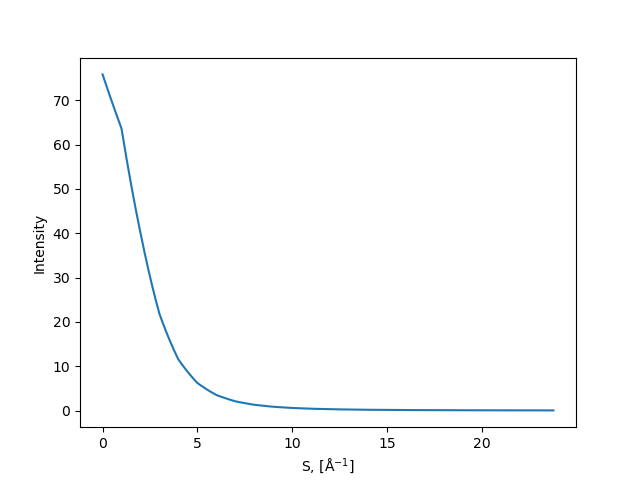

In [78]:
I_atomic_all = np.array(I_atomic_all)
#print(len(I_atomic_all))
I_atomic = sum(I_atomic_all)
#print(len(I_atomic))
#print(I_atomic)

angs = '\u00C5'

plt.figure()
plt.plot(s_new, I_atomic, label = "I atomic")
plt.xlabel(r'S, ['+angs+'$^{-1}$]')
plt.ylabel("Intensity")
plt.show()

### Calculate I molecular

In [79]:
U=90000; #Acceleration field in V
E=U*1.6022*1e-19;
m=9.1094e-31;
h=6.6261e-34;
c=299792458; #Physical constants
lam=h/np.sqrt(2*m*E)/np.sqrt(1+E/(2*m*c**2)); #Electron wavelength
k=2*np.pi/lam;

In [85]:
test = get_I_molecular(atoms, x, y, z, n, ds, s0, amps, phase, idx_all)
print(len(test))
test = [i for i in test if len(i) != 0]
print(len(test))
test_sum = sum(np.array(test))
print(len(test))

test_nonan = np.nan_to_num(test_sum)
print(len(test_nonan))
test_real = test_nonan.real
print(len(test_real))
I_mol = test_real
print(len(I_mol))

C:\Users\laure\AppData\Local\Temp\ipykernel_3904\1018650557.py:117: RuntimeWarning: invalid value encountered in double_scalars
  I_m = (amps_new_i[k])*np.conjugate(amps_new_j[k])*(np.sin(s_new[k]*r_ij)/(s_new[k]*r_ij))


225
210
210
1000
1000
998


In [81]:
I_tot = I_mol + I_atomic

<function matplotlib.pyplot.show(block=None)>

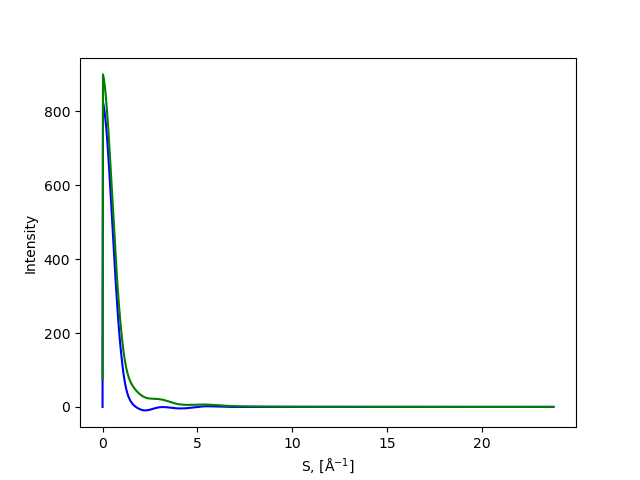

In [86]:
plt.figure()
plt.plot(s_new, I_mol, "b", label = "I molecular")
plt.plot(s_new, I_tot, "g", label="I total")
plt.xlabel(r'S, ['+angs+'$^{-1}$]')
plt.ylabel("Intensity")
plt.show

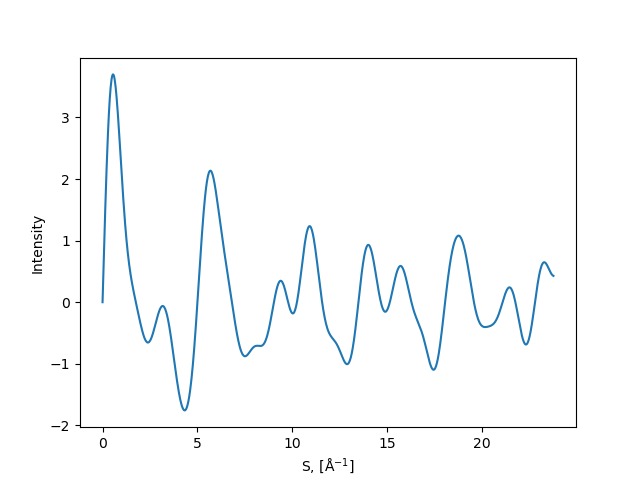

In [95]:
sm = s_new*(I_mol/I_atomic)

plt.figure()
plt.plot(s_new, sm)
plt.xlabel(r'S, ['+angs+'$^{-1}$]')
plt.ylabel("Intensity")
plt.show()

## Fitting Data to Theory

In [ ]:
def fitting_function(xy,xcenter,ycenter,z0,amplitude):
    x = np.ravel(xy[0])
    y = np.ravel(xy[1])
    xcent = x-xcenter
    ycent = y-ycenter
    r_xy = np.sqrt(xcent**2+ycent**2)
    theta = np.arctan(r_xy/z0)
    Q_abs = theta_to_q(theta)
    ff = amplitude*form_factor(Q_abs)
    thomson_correction = 1/get_thomson_correction(xcent,ycent,z0)
    geometry_correction = 1/get_geometry_correction(xcent,ycent,z0)
    ff = ff*thomson_correction*geometry_correction
    return ff

def get_1d_fit(params,fitting_function):
    x0,y0,z0 = params[0],params[1],params[2]
    if len(params<5):
        phi0 = 0
    elif len(params)==5:
        phi0 = params[4]
    thomson_correction = get_thomson_correction(x-x0,y-y0,z0,phi0=phi0)
    PHI = xyz_to_phi(x-x0,y-y0,z0)
    geometry_correction = get_geometry_correction(x-x0,y-y0,z0)
    all_corrections = thomson_correction*geometry_correction
    fit_pattern = np.reshape(fitting_function([x,y],*params),(8,512,1024))*all_corrections
    data_corrected = jungfrau_sum*all_corrections

    QQ_data = xyz_to_q(x-x0,y-y0,z0)
    isotropic_data_1d = []
    isotropic_fit_1d = []
    QQ_1d_data = np.linspace(np.min(QQ_data),np.max(QQ_data),51)
    dQQ_1d_data = np.mean(np.diff(QQ_1d_data))
    QQ_1d_data = QQ_1d_data[:-1]
    residuals = []
    sems = []
    from scipy.stats import sem
    for qval in QQ_1d_data:
        isotropic_data_1d.append(np.mean(data_corrected[(QQ_data>qval)&(QQ_data<qval+dQQ_1d_data)]))
        sems.append(sem(data_corrected[(QQ_data>qval)&(QQ_data<qval+dQQ_1d_data)]))
        isotropic_fit_1d.append(np.mean(fit_pattern[(QQ_data>qval)&(QQ_data<qval+dQQ_1d_data)]))
        residuals.append(np.mean(np.abs((jungfrau_sum-fit_pattern)[(QQ_data>qval)&(QQ_data<qval+dQQ_1d_data)])))
    return QQ_1d_data, isotropic_data_1d, isotropic_fit_1d, fit_pattern

In [97]:
data = I_mol/I_atomic

s_guess = 0.022
def func(data, s_guess):
    return s_guess*data

parameters, covariance = curve_fit(func, s_new, data)